# 1 Introduction

This project is based on the criteria from a Kaggle Natural Language Processing Competition:

https://www.kaggle.com/c/nlp-getting-started/overview

## 1.1 Problem Description

The objective of this project is to develop a model that can predict whether a given tweet is about a real disaster or not. Tweets serve as a vital communication tool during disasters, but they can also contain misinformation or non-disaster-related content. The goal is to accurately classify tweets as disaster-related (label 1) or not disaster-related (label 0).

## 1.2 Dataset Import

The data can be found at:

https://www.kaggle.com/c/nlp-getting-started/data

### Data Import

To start with, the datasets including the training set, test set, and sample submission file were loaded using the Pandas library. The training set contains the tweets and their associated labels, while the test set contains tweets without labels which need to be predicted. The sample submission file serves as a template for the format of the prediction submission.

### Initial Dataset Overview

After importing the datasets, an initial overview was conducted to understand the structure and contents of the data.

The training set overview is as follows:

- Shape of Train Set: 7613 rows and 5 columns
- Columns in Train Set: id, keyword, location, text, target
- Data Types of Columns: id (int64), keyword (object), location (object), text (object), target (int64)
- Total Unique ID Values: 7613 (no duplicates)
- Missing Values in ID Column: 0
- Total Unique Keywords: 221
- Missing Values in Keyword Column: 61
- Total Unique Locations: 3341
- Missing Values in Location Column: 2533
- Total Unique Words in Text Column: 31924
- Missing Values in Text Column: 0
- Minimum Unique Words in Text: 1
- Mean Unique Words in Text: 14.34
- Maximum Unique Words in Text: 29
- Total Unique Target Values: 2 (0 or 1)
- Missing Values in Target Column: 0

In [ ]:
from itertools import product
import numpy as np
import pandas as pd
import contractions
import geonamescache
import matplotlib.pyplot as plt
import nltk
import pycountry
import re
import seaborn as sns
import string
import unicodedata
from collections import Counter
from nltk.corpus import stopwords, words, names, wordnet
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# # Initialize NLTK components and spell checker
# nltk.download('words')
# nltk.download('names')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

#!kaggle competitions download -c nlp-getting-started
#!unzip nlp-getting-started.zip

In [ ]:
# Load the training, test, and sample submission data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

# Combine the test data and sample submission file
test_df = pd.merge(test_df, sample_submission_df, on='id')

# Description of the dataset
print('TRAIN OVERVIEW',
      '\n\nSHAPE OF TRAIN: ', train_df.shape,
      '\n\nCOLUMNS IN TRAIN: ', train_df.columns,
      '\n\nDATA TYPES OF COLUMNS IN TRAIN:\n', train_df.dtypes,
      '\n\nTOTAL UNIQUE ID VALUES: ', train_df['id'].nunique(),
      '\n\nNUMBER OF NA VALUES IN ID COLUMN: ', train_df['id'].isna().sum(),
      '\n\nTOTAL UNIQUE KEYWORDS IN KEYWORD COLUMN: ', train_df['keyword'].nunique(),
      '\n\nNUMBER OF NA VALUES IN KEYWORD COLUMN: ', train_df['keyword'].isna().sum(),
      '\n\nTOTAL UNIQUE LOCATIONS IN LOCATION COLUMN: ', train_df['location'].nunique(),
      '\n\nNUMBER OF NA VALUES IN LOCATION COLUMN: ', train_df['location'].isna().sum(),
      '\n\nTOTAL UNIQUE WORDS IN TEXT COLUMN: ', len(set(" ".join(train_df['text']).split())),
      '\n\nNUMBER OF NA VALUES IN TEXT COLUMN: ', train_df['text'].isna().sum(),
      '\n\nMINIMUM UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).min(),
      '\n\nMEAN UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).mean(),
      '\n\nMAXIMUM UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).max(),
      '\n\nTOTAL UNIQUE TARGET VALUES: ', train_df['target'].nunique(),
      '\n\nNUMBER OF NA VALUES IN TARGET COLUMN: ', train_df['target'].isna().sum(),
      '\n\nHEAD OF TRAIN: \n\n', train_df.head(), '\n\n')

TRAIN OVERVIEW 

SHAPE OF TRAIN:  (7613, 5) 

COLUMNS IN TRAIN:  Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object') 

DATA TYPES OF COLUMNS IN TRAIN:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object 

TOTAL UNIQUE ID VALUES:  7613 

NUMBER OF NA VALUES IN ID COLUMN:  0 

TOTAL UNIQUE KEYWORDS IN KEYWORD COLUMN:  221 

NUMBER OF NA VALUES IN KEYWORD COLUMN:  61 

TOTAL UNIQUE LOCATIONS IN LOCATION COLUMN:  3341 

NUMBER OF NA VALUES IN LOCATION COLUMN:  2533 

TOTAL UNIQUE WORDS IN TEXT COLUMN:  31924 

NUMBER OF NA VALUES IN TEXT COLUMN:  0 

MINIMUM UNIQUE WORDS IN TEXT COLUMN:  1 

MEAN UNIQUE WORDS IN TEXT COLUMN:  14.340732956784448 

MAXIMUM UNIQUE WORDS IN TEXT COLUMN:  29 

TOTAL UNIQUE TARGET VALUES:  2 

NUMBER OF NA VALUES IN TARGET COLUMN:  0 

HEAD OF TRAIN: 

    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #

## 1.3 Data Cleaning

The data cleaning process was pivotal in preparing the dataset for analysis and modeling. Given that the 'text' column is useful for helping to find the missing values of 'keyword' and 'location', the cleaning process began with text.

### Text

The text column underwent several cleaning steps to enhance readability and analysis. Initially containing a diverse range of natural language, the cleaned version reduced the total unique words from 31,924 to 11,971. This reduction helps streamline natural language processing tasks by focusing on the most relevant terms and eliminating noise. Notably, the mean unique words per entry decreased from approximately 14.34 to 8.69, with the maximum unique words per entry reduced from 29 to 21. This normalization enhances the dataset’s consistency and prepares it for efficient keyword extraction and text-based analysis.

### Keyword

In the keyword column, the dataset originally included 221 unique keywords, which decreased to 167 after cleaning. Notably, 61 entries originally lacked keywords and 40 of those were successfully categorized into existing categories while the other 21 were labelled as 'other'. This standardization ensures uniformity across entries, facilitating more accurate classification and analysis based on specific disaster-related keywords.

### Location

The location column presented significant challenges due to its free-form nature, resulting in 3,341 unique entries. Through cleaning and normalization efforts, the number of unique locations decreased to 2,144. Importantly, 2,533 entries originally lacked specific locations but 664 were categorized under existing locations and the remaining 1,869 were successfully categorized under a generalized 'other' category. This consolidation enhances the dataset’s clarity and improves the accuracy of geospatial analysis, particularly in identifying disaster occurrences across different regions.

By systematically cleaning and standardizing these columns, the dataset now offers improved consistency and reliability for subsequent modeling and analytical tasks. These efforts ensure that the data is optimized for detecting disaster-related events based on keywords and geographical indicators without introducing bias or inconsistency.

In [ ]:
%run ./NPL_Disaster_Tweets_clean_lists.ipynb

In [ ]:
gc = geonamescache.GeonamesCache()

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the sets with lowercase entries
valid_words = set(word.lower() for word in words.words())
valid_words.update(word.lower() for word in nltk.corpus.words.words())

# # Function to clean names by replacing special characters with spaces and removing double spaces
def clean_name(name):
    # Replace '-', ',', '.' with a space
    name = re.sub(r'[-,.]', ' ', name)
    # Remove non-alphabetic characters and replace with a space
    name = re.sub(r'[^a-zA-Z\s]', '', name)
    # Remove double spaces
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Clean the countries set
cleaned_countries = set(clean_name(country) for country in countries)
# Update the countries set
countries = cleaned_countries

# Clean and filter the city names
cleaned_cities = [clean_name(city) for city in cities]
cleaned_cities = [city for city in cleaned_cities if clean_name(city) != 'york']
cities = cleaned_cities

# Remove city names with less than five characters
cities = [city for city in cities if len(city) >= 6]

# Merge both lists (remove duplicates)
cities = list(set(cities + short_city_names))

# Sort cities by length from longest to shortest
sorted_cities = sorted(cities, key=len, reverse=True)

valid_terms = valid_words.union(valid_names, countries, cities, companies, continents, acronyms, products, geographic_regions)


# Initialize the spell checker
spell = SpellChecker()

# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove links (websites) and handles
    text = re.sub(r'http\S+|www\.\S+|\S+\.(com|net)|@\S+', '', text)

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Replace British English words
    words = [british_english_words.get(word, word) for word in words]

    # Tag parts of speech
    pos_tags = nltk.pos_tag(words)

    # Remove punctuation (after tagging)
    words = [word for word in words if word not in string.punctuation]

    # Replace numbers with commas with "TOKENNUM"
    text = re.sub(r'\b\d{1,3}(,\d{3})+\b', 'TOKENNUM',' '.join(words))

    # Replace currency symbols with "TOKENCURRENCY"
    text = re.sub(r'(\$\d+|\£\d+|\¢\d+)', 'TOKENCURRENCY', text)

    # Replace any non-alphanumeric characters except spaces with a space
    text = re.sub(r'[^a-zA-Z0-9_]+', ' ', text)

    # Remove double spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Replace decades like "1920s" or "1920 s" with "token_decade"
    text = re.sub(r'\b\d{4}s?\b', 'token_decade', text)

    # Replace years with "token_year"
    text = re.sub(r'\b(19|20)\d{2}\b', 'token_year', text)

    # Replace times in the format 00:00, 1:23, 00 00, or 1 23 followed by "utc" or a space and then "utc" with "token_time"
    text = re.sub(r'\b\d{1,2}[: ]\d{2}\s?utc\b', 'token_time', text)

    # Replace numbers followed by am or pm with "token_time"
    text = re.sub(r'\b\d+(am|pm)\b', 'token_time', text)

    # Replace numbers followed by oz or ml with "token_volume"
    text = re.sub(r'\b\d+(oz|ml)\b', 'token_time', text)

    # Replace numeric numbers followed by m or km with "token_distance"
    text = re.sub(r'\b\d+(\.\d+)?\s*(m|meter|meters|km|in|inch|ft|feet|foot)\b', 'token_distance', text)

    # Replace numbers followed by c or f with "token_temperature"
    text = re.sub(r'\b\d+(\.\d+)?\s*(c|f)\b', 'token_temperature', text)

    # Replace ordinal numbers followed by st, nd, rd, th with "token_ordinal"
    text = re.sub(r'\b\d+(\.\d+)?\s*(st|nd|rd|th)\b', 'token_ordinal', text)

    # Replace sequences of just numbers with "token_num"
    text = re.sub(r'\b\d+\b', 'token_num', text)

    # Replace numbers followed by am or pm with "token_time"
    text = re.sub(r'\b\d+(k)\b', 'token_num', text)

    # Replace "TOKENNUM" with "token_num"
    text = re.sub(r'TOKENNUM', 'token_num', text)

    # Replace "TOKENCURRENCY" with "token_currency"
    text = re.sub(r'TOKENCURRENCY', 'token_currency', text)

    # Replace numbers followed by "yearold", "yearsold", " year old", or " years old" with "token_age"
    text = re.sub(r'\b\d+(\s*year(s)?\s*old|(\s*yrs)?(\s*old)?)\b', 'token_age', text)

    # Tokenize the modified text again into words
    words = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization using POS tags
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

    # Join words back into a cleaned text
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the cleaning function to the text column in train and test datasets
train_df['text_cleaned'] = train_df['text'].apply(clean_text)
test_df['text_cleaned'] = test_df['text'].apply(clean_text)

In [ ]:
# Initialize the spell checker
spell_us = SpellChecker()

def process_unknown_words(text, spell_checker):
    # Tokenize the text into words
    word_list = nltk.word_tokenize(text)

    # Filter out known terms, spell checker's suggestions, and tokens
    unknown_words = [word for word in word_list if word.lower() not in valid_terms and not word.startswith('token_')]

    # Correct misspellings and split concatenated words
    corrected_words = []
    for word in unknown_words:
        # Check if the word is in the spell checker suggestions
        if word.lower() in spell_checker:
            corrected_words.append(word)
        else:
            # Handle plural forms and common suffixes
            if word.lower().endswith(tuple(common_suffixes)):
                # Consider these as valid terms or handle them appropriately
                corrected_words.append(word)
            else:
                # Try to split concatenated words using regex patterns
                splits = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z][a-z])|[\'\w]+', word)
                splits = [split.lower() for split in splits if split]

                # Further process each split
                processed_splits = []
                for split in splits:
                    if split in valid_terms or split in spell_checker:
                        processed_splits.append(split)
                    else:
                        # Check if smaller splits are valid terms
                        smaller_splits = re.findall(r'[A-Z]?[a-z]+', split)
                        smaller_splits = [smaller_split.lower() for smaller_split in smaller_splits if smaller_split]
                        processed_splits.extend(smaller_splits)

                if processed_splits:
                    corrected_words.extend(processed_splits)
                else:
                    corrected_words.append(word)  # Default to original word if no valid splits found

    return corrected_words

train_unknown_words = train_df['text_cleaned'].apply(process_unknown_words, spell_checker=spell_us)
test_unknown_words = test_df['text_cleaned'].apply(process_unknown_words, spell_checker=spell_us)

In [ ]:
# Function to check for non-letter characters in a string
def contains_non_letter_characters(keyword):
    return bool(re.search(r'[^a-zA-Z]', str(keyword)))

# Function to extract both single-word and two-word keywords
def extract_keywords(keywords):
    single_word_keywords = set()
    two_word_keywords = set()

    for keyword in keywords:
        if ' ' in keyword:
            two_word_keywords.add(keyword)
        else:
            single_word_keywords.add(keyword)

    return list(single_word_keywords), list(two_word_keywords)

# Function to normalize keywords
def normalize_keywords(text):
    # Replace '%20' with space
    normalized_text = re.sub(r'%20', ' ', str(text))
    # Remove special characters, hashtags, quotes, and convert to lowercase
    normalized_text = re.sub(r"[^a-zA-Z\s]", "", normalized_text)  # Remove non-alphabetic characters
    normalized_text = normalized_text.lower().strip()  # Convert to lowercase and strip spaces
    return normalized_text

# Function to match keywords
def match_keywords(text_cleaned, single_word_keywords, two_word_keywords):
    normalized_text = normalize_keywords(text_cleaned)

    # Match two-word keywords
    for keyword in two_word_keywords:
        if keyword in normalized_text:
            return keyword

    # Match single-word keywords
    for keyword in single_word_keywords:
        if re.search(r'\b{}\b'.format(re.escape(keyword)), normalized_text):
            return keyword

    return None

# Extract keywords from train_df and test_df combined
all_keywords = set(train_df['keyword'].dropna().unique()).union(set(test_df['keyword'].dropna().unique()))
single_word_keywords, two_word_keywords = extract_keywords(all_keywords)

# Process rows with NaN keywords in train_df and test_df
def fill_missing_keywords(df):
    df['keyword_cleaned'] = df['keyword'].str.replace('%20', ' ')
    for index, row in df[df['keyword_cleaned'].isnull()].iterrows():
        matched_keyword = match_keywords(row['text_cleaned'], single_word_keywords, two_word_keywords)
        if matched_keyword:
            df.at[index, 'keyword_cleaned'] = matched_keyword
    df['keyword_cleaned'].fillna('other', inplace=True)
    return df

train_df = fill_missing_keywords(train_df)
test_df = fill_missing_keywords(test_df)

def consolidate_keywords(df, keyword_consolidation_map):
    df['keyword_cleaned'] = df['keyword_cleaned'].replace(keyword_consolidation_map)
    return df

train_df = consolidate_keywords(train_df, keyword_consolidation_map)
test_df = consolidate_keywords(test_df, keyword_consolidation_map)

In [ ]:
# Function to remove punctuation from a string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to normalize text, replacing incorrect characters with correct ones
def normalize_location(location):
    normalized_text = unicodedata.normalize('NFD', location).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text.lower().strip()  # Convert to lowercase and strip spaces

# Function to remove whole words that are just numbers
def remove_number_words(text):
    return ' '.join(word for word in text.split() if not word.isdigit())

# Function to clean the location column, only applying to non-NaN values
def clean_location_column(df):
    cleaned_ids = []
    cleaned_locations = []
    for idx, loc in zip(df['id'], df['location']):
        if pd.isnull(loc) or loc.strip() == "":
            continue  # Skip NaN values and empty strings
        else:
            cleaned_loc = remove_punctuation(loc)
            cleaned_loc = normalize_location(cleaned_loc)
            cleaned_loc = remove_number_words(cleaned_loc)
            cleaned_loc = re.sub(r'\s+', ' ', cleaned_loc).strip()  # Remove double spaces and strip
            if cleaned_loc:  # Only add non-empty cleaned locations
                cleaned_ids.append(idx)
                cleaned_locations.append(cleaned_loc)
    return pd.DataFrame({'id': cleaned_ids, 'location_clean': cleaned_locations})

# Do preliminary clean of the location columns in train and test DataFrames
cleaned_locations_train_df = clean_location_column(train_df)
cleaned_locations_test_df = clean_location_column(test_df)
cleaned_locations_train_df['location_cleaned'] = np.nan
cleaned_locations_train_df = cleaned_locations_train_df.reset_index(drop=True)
cleaned_locations_test_df['location_cleaned'] = np.nan
cleaned_locations_test_df = cleaned_locations_test_df.reset_index(drop=True)

# Combine countries and common country corrections
extended_countries = countries.union(country_common_to_full.keys())

# Create cities_with_exemption
cities_with_exemption = [city for city in cities if city.lower() not in exempt_city_names]

# Create a regular expression pattern with word boundaries
web_types_pattern = r'\b(?:' + '|'.join(web_types) + r')\b'

In [ ]:
class CleanLocation:
    def __init__(self, cities, city_corrections, us_state_names, us_state_abb_to_name, us_state_corrections,
                 countries, country_corrections, country_common_to_full, continents, region_terms, global_regions,
                 global_regions_corrections, global_terms, global_term_corrections, web_types_pattern,
                 misc_corrections):
        self.cities = cities
        self.city_corrections = city_corrections
        self.us_state_names = us_state_names
        self.us_state_abb_to_name = us_state_abb_to_name
        self.us_state_corrections = us_state_corrections
        self.countries = countries
        self.country_corrections = country_corrections
        self.country_common_to_full = country_common_to_full
        self.continents = continents
        self.region_terms = region_terms
        self.global_regions = global_regions
        self.global_regions_corrections = global_regions_corrections
        self.global_terms = global_terms
        self.global_term_corrections = global_term_corrections
        self.web_types_pattern = web_types_pattern
        self.misc_corrections = misc_corrections

    def apply_city_corrections(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.city_corrections:
            return self.city_corrections[row['location_clean']]
        return row['location_cleaned']

    def apply_city_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.cities:
            return row['location_clean']
        return row['location_cleaned']

    def city_additional_conditions(self, row):
        location_clean = row['location_clean']
        if pd.isna(location_clean):
            return location_clean
        words = location_clean.split()
        if len(words) == 1 and words[0] in self.cities:
            return words[0]
        for i in range(1, len(words)):
            city_part = ' '.join(words[:i])
            state_country_abbrev_part = ' '.join(words[i:]).lower()

            if city_part in self.cities:
                if (state_country_abbrev_part in self.us_state_names or
                    state_country_abbrev_part in self.countries or
                    re.match(r'^[a-z]{2}$', state_country_abbrev_part) or
                    state_country_abbrev_part in self.country_common_to_full):
                    return city_part
        return np.nan

    def city_additional_conditions_spacing_us_states(self, row):
        location_cleaned = row['location_cleaned']
        location_clean = row['location_clean']
        if pd.isna(location_cleaned) and isinstance(location_clean, str):
            for state_abb, state_name in us_state_abb_to_name.items():
                state_part = state_name.replace(' ', '')
                if state_part in location_clean.lower():
                    for city in cities:
                        city_part = city.replace(' ', '')
                        if city_part in location_clean.lower() and state_part in location_clean.lower():
                            return city
        return location_cleaned

    def city_additional_conditions_spacing(self, row):
        location_cleaned = row['location_cleaned']
        location_clean = row['location_clean']

        if pd.isna(location_cleaned) and isinstance(location_clean, str):
            for country in extended_countries:
                if country in location_clean.lower():
                    country_part = country.replace(' ', '')
                    for city in cities:
                        city_part = city.replace(' ', '')
                        if city_part in location_clean.lower() and country_part in location_clean.lower():
                            return city
        return location_cleaned

    def apply_us_state_corrections(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.us_state_corrections:
            return self.us_state_corrections[row['location_clean']]
        return row['location_cleaned']

    def apply_us_state_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.us_state_names:
            return row['location_clean']
        return row['location_cleaned']

    def us_state_additional_conditions(self, location):
        if pd.isna(location):
            return location

        words = location.split()

        for i in range(1, min(3, len(words) + 1)):
            state_part = ' '.join(words[:i]).lower()
            additional_part = ' '.join(words[i:]).lower()

            if state_part in self.us_state_names:
                if additional_part in {'usa', 'us', 'united states', 'united states of america'}:
                    return state_part
                if additional_part in {'north', 'south', 'east', 'west'}:  # Adjust based on your geographic directions list
                    return state_part

        return np.nan

    def apply_country_corrections(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.country_corrections:
            return self.country_corrections[row['location_clean']]
        return row['location_cleaned']

    def apply_country_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.countries:
            return row['location_clean']
        return row['location_cleaned']

    def apply_country_common_to_full(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.country_common_to_full:
            return self.country_common_to_full[row['location_clean']]
        return row['location_cleaned']

    def apply_continent_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.continents:
            return row['location_clean']
        return row['location_cleaned']

    def apply_region_terms_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.region_terms:
            return row['location_clean']
        return row['location_cleaned']

    def apply_global_regions_corrections(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.global_regions_corrections:
            return self.global_regions_corrections[row['location_clean']]
        return row['location_cleaned']

    def apply_global_regions_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.global_regions:
            return row['location_clean']
        return row['location_cleaned']

    def apply_global_term_corrections(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.global_term_corrections:
            return self.global_term_corrections[row['location_clean']]
        return row['location_cleaned']

    def apply_global_terms_exact(self, row):
        if pd.isna(row['location_cleaned']) and row['location_clean'] in self.global_terms:
            return row['location_clean']
        return row['location_cleaned']

    def remaining_us_state(self, row):
        if pd.isna(row['location_cleaned']) and isinstance(row['location_clean'], str):
            location_clean_lower = row['location_clean'].lower()
            for state in self.us_state_names:
                if state in location_clean_lower:
                    return state
        return row['location_cleaned']

    def remaining_countries(self, row):
        if pd.isna(row['location_cleaned']) and isinstance(row['location_clean'], str):
            location_clean_lower = row['location_clean'].lower()
            for country in self.countries:
                if country in location_clean_lower:
                    return country
        return row['location_cleaned']

    def remaining_cities_with_regions(self, row):
        if pd.isna(row['location_cleaned']):
            location_clean_lower = row['location_clean'].lower()

            for city in self.cities:
                city_lower = city.lower()
                if city_lower in location_clean_lower:
                    remainder = location_clean_lower.replace(city_lower, '').strip()
                    if (remainder in self.us_state_names or
                        remainder in self.us_state_abb_to_name.keys() or
                        remainder in self.global_regions):
                        return city
        return row['location_cleaned']

    def apply_web_exact(self, row):
        if pd.isna(row['location_cleaned']):
            location_clean_lower = row['location_clean'].lower()
            match = re.search(self.web_types_pattern, location_clean_lower, re.IGNORECASE)
            if match:
                return match.group(0)
        return row['location_cleaned']

    def apply_misc_corrections(self, row):
        if pd.isna(row['location_cleaned']) and isinstance(row['location_clean'], str):
            location_clean_lower = row['location_clean'].lower()
            for key, value in self.misc_corrections.items():
                if key == location_clean_lower:
                    return value
        return row['location_cleaned']

    def apply_city_remaining(self, row):
        if pd.isna(row['location_cleaned']) and isinstance(row['location_clean'], str):
            location_clean_lower = row['location_clean'].lower()
            for city in sorted(self.cities, key=len, reverse=True):
                city_lower = city.lower()
                if city_lower in location_clean_lower:
                    return city
        return row['location_cleaned']

    def apply_us_state_abb_exact(self, row):
        if pd.isna(row['location_cleaned']) and isinstance(row['location_clean'], str):
            location_clean_lower = row['location_clean'].lower()
            if location_clean_lower in self.us_state_abb_to_name:
                return self.us_state_abb_to_name[location_clean_lower]
        return row['location_cleaned']

    def fill_remaining_with_clean(self, row):
        if pd.isna(row['location_cleaned']):
            return row['location_clean']
        return row['location_cleaned']

    def apply_cleaning_steps(self, df):
        df['location_cleaned'] = df.apply(self.apply_city_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_city_exact, axis=1)
        df.loc[df['location_cleaned'].isnull(), 'location_cleaned'] = df.apply(lambda row: self.city_additional_conditions(row), axis=1)
        df.loc[df['location_cleaned'].isnull(), 'location_cleaned'] = df.apply(lambda row: self.city_additional_conditions_spacing_us_states(row), axis=1)
        df.loc[df['location_cleaned'].isnull(), 'location_cleaned'] = df.apply(lambda row: self.city_additional_conditions_spacing(row), axis=1)
        df['location_cleaned'] = df.apply(self.apply_us_state_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_us_state_exact, axis=1)
        df.loc[df['location_cleaned'].isnull(), 'location_cleaned'] = df['location_clean'].apply(self.us_state_additional_conditions)
        df['location_cleaned'] = df.apply(self.apply_country_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_country_exact, axis=1)
        df['location_cleaned'] = df.apply(self.apply_country_common_to_full, axis=1)
        df['location_cleaned'] = df.apply(self.apply_continent_exact, axis=1)
        df['location_cleaned'] = df.apply(self.apply_region_terms_exact, axis=1)
        df['location_cleaned'] = df.apply(self.apply_global_regions_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_global_regions_exact, axis=1)
        df['location_cleaned'] = df.apply(self.apply_global_term_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_global_terms_exact, axis=1)
        df['location_cleaned'] = df.apply(self.remaining_us_state, axis=1)
        df['location_cleaned'] = df.apply(self.remaining_countries, axis=1)
        df['location_cleaned'] = df.apply(self.remaining_cities_with_regions, axis=1)
        df['location_cleaned'] = df.apply(self.apply_web_exact, axis=1)
        df['location_cleaned'] = df.apply(self.apply_misc_corrections, axis=1)
        df['location_cleaned'] = df.apply(self.apply_city_remaining, axis=1)
        df['location_cleaned'] = df.apply(self.apply_us_state_abb_exact, axis=1)
        df['location_cleaned'] = df.apply(self.fill_remaining_with_clean, axis=1)
        return df

cleaner = CleanLocation(cities=cities,
                        city_corrections=city_corrections,
                        us_state_names=us_state_names,
                        us_state_abb_to_name=us_state_abb_to_name,
                        us_state_corrections=us_state_corrections,
                        countries=countries,
                        country_corrections=country_corrections,
                        country_common_to_full=country_common_to_full,
                        continents=continents,
                        region_terms=region_terms,
                        global_regions=global_regions,
                        global_regions_corrections=global_regions_corrections,
                        global_terms=global_terms,
                        global_term_corrections=global_term_corrections,
                        web_types_pattern=web_types_pattern,
                        misc_corrections=misc_corrections)

# Assuming cleaned_locations_train_df and cleaned_locations_test_df are your DataFrames
cleaned_locations_train_df = cleaner.apply_cleaning_steps(cleaned_locations_train_df)
cleaned_locations_test_df = cleaner.apply_cleaning_steps(cleaned_locations_test_df)

# Apply to original dataframes
train_df = train_df.merge(cleaned_locations_train_df[['id', 'location_cleaned']], how='left', on='id')
test_df = test_df.merge(cleaned_locations_test_df[['id', 'location_cleaned']], how='left', on='id')

In [ ]:
# Create copies of the DataFrames to ensure operations are performed on the copies
rows_missing_location_cleaned_train = train_df[(train_df['location'].notna()) & (train_df['location_cleaned'].isna())]
rows_missing_location_cleaned_test = test_df[(test_df['location'].notna()) & (test_df['location_cleaned'].isna())]
rows_missing_location_cleaned_train = rows_missing_location_cleaned_train.copy()
rows_missing_location_cleaned_test = rows_missing_location_cleaned_test.copy()

# Fill 'location' with NaN for rows_missing_location_cleaned_train
rows_missing_location_cleaned_train.loc[:, 'location'] = np.nan

# Fill 'location' with NaN for rows_missing_location_cleaned_test
rows_missing_location_cleaned_test.loc[:, 'location'] = np.nan

# Concatenate train_df and test_df
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Filter rows where location column is NaN
locations_nans = combined_df[combined_df['location'].isna()]

# Reset the index
locations_nans.reset_index(drop=True, inplace=True)

#Extract relevant columns for locations_nans
columns_to_add = ['id', 'location', 'keyword', 'keyword_cleaned', 'target', 'text', 'text_cleaned']

#Concatenate filtered rows from train_df and test_df to locations_nans
locations_nans = pd.concat([locations_nans,
                            rows_missing_location_cleaned_train[columns_to_add],
                            rows_missing_location_cleaned_test[columns_to_add]],
                           ignore_index=True)

# Combine location_cleaned columns from both DataFrames
combined_cleaned_locations = pd.concat([
    cleaned_locations_train_df['location_cleaned'],
    cleaned_locations_test_df['location_cleaned']
], ignore_index=True).dropna().unique().tolist()

# Find set of cities in use
valid_cities = set(cities).intersection(combined_cleaned_locations)

# Sort valid cities by length from longest to shortest
sorted_valid_cities = sorted(valid_cities, key=len, reverse=True)

# Find set of countries in use
valid_countries = set(countries).intersection(combined_cleaned_locations)

# Sort valid countries by length from longest to shortest
sorted_valid_countries = sorted(valid_countries, key=len, reverse=True)

In [ ]:
# Function to find valid cities in text
def find_city_in_text(text, sorted_valid_cities, common_to_full, location_cleaned):
    # Check if location_cleaned is NaN
    if pd.isna(location_cleaned):
        # Check for common abbreviations and return full name
        for abbrev, full_name in common_to_full.items():
            pattern = r'\b{}\b'.format(re.escape(abbrev.lower()))
            if re.search(pattern, text.lower()):
                return full_name

        # Check for full city names
        for city in sorted_valid_cities:
            pattern = r'\b{}\b'.format(re.escape(city.lower()))
            if re.search(pattern, text.lower()):
                return city

    return location_cleaned

# Function to find valid us states in text
def find_us_state_name_in_text(locations_nans, us_state_names, us_state_corrections):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            found_state = None

            # Check for US state names
            for state in us_state_names:
                if state in text_cleaned.lower():
                    found_state = state
                    break

            # If no US state name found, check us_state_corrections
            if found_state is None:
                for state, correction in us_state_corrections.items():
                    if state in text_cleaned.lower():
                        found_state = correction
                        break

            if found_state:
                locations_nans.at[index, 'location_cleaned'] = found_state

    return locations_nans

# Function to find global regions in text
def find_global_region_in_text(locations_nans, global_regions):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            for region in global_regions:
                if region in text_cleaned.lower():
                    locations_nans.at[index, 'location_cleaned'] = region
                    break
    return locations_nans

# Function to find continents in text
def find_continents_in_text(locations_nans, continents):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            for continent in continents:
                if continent in text_cleaned.lower():
                    locations_nans.at[index, 'location_cleaned'] = continent
                    break
    return locations_nans

# Function to find countries in text
def find_country_name_in_text(locations_nans, sorted_valid_countries, country_common_to_full, countries):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            found_country = None

            # Check if any sorted_valid_countries is found in text_cleaned
            for country in sorted_valid_countries:
                if country in text_cleaned.lower():
                    found_country = country
                    break

            # If no valid country is found, check for country_common_to_full keys longer than 4 characters
            if found_country is None:
                for country, full_name in country_common_to_full.items():
                    if len(country) > 4 and country in text_cleaned.lower():
                        found_country = full_name
                        break

            # If no valid country is found, check the rest of countries
            if found_country is None:
                for country in countries:
                    if country in text_cleaned.lower():
                        found_country = country
                        break

            # Add condition for uk
            if found_country is None:
                if ' uk ' in text_cleaned.lower() or text_cleaned.lower().startswith('uk ') or text_cleaned.lower().endswith(' uk'):
                    found_country = 'united kingdom'

            # Update location_cleaned if a country name is found
            if found_country:
                locations_nans.at[index, 'location_cleaned'] = found_country

    return locations_nans

# Function to find additional cities in text
def find_additional_cities_in_text(locations_nans, sorted_valid_cities, city_corrections, cities_with_exemption):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            found_city = None

            for city in sorted_valid_cities:
                if len(city) > 4 and city in text_cleaned.lower():
                    found_city = city
                    break

            if found_city is None:
                for city, full_name in city_corrections.items():
                    if len(city) > 2 and city in text_cleaned.lower():
                        found_city = full_name
                        break

            if found_city is None:
                for city in cities_with_exemption:
                    if len(city) > 4 and city in text_cleaned.lower():
                        found_city = city
                        break

            if found_city:
                locations_nans.at[index, 'location_cleaned'] = found_city

    return locations_nans

# Function to find valid misc corrections
def find_misc_corrections_in_text(locations_nans, misc_corrections):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            found_correction = None

            for misc, correction in misc_corrections.items():
                if misc in text_cleaned.lower():
                    found_correction = correction
                    break

            if found_correction:
                locations_nans.at[index, 'location_cleaned'] = found_correction

    return locations_nans

# Function to find web_types
def find_web_types_in_text(locations_nans, web_types):
    for index, row in locations_nans.iterrows():
        if pd.isna(row['location_cleaned']):
            text_cleaned = row['text_cleaned']
            found_type = None
            for type in web_types:
                if len(type) > 2 and type.lower() in text_cleaned.lower():
                    found_type = type
                    break
            if found_type:
                locations_nans.at[index, 'location_cleaned'] = found_type
    return locations_nans

In [ ]:
# Apply find_city_in_text function
locations_nans['location_cleaned'] = locations_nans.apply(lambda row: find_city_in_text(row['text_cleaned'], sorted_valid_cities, city_common_to_full, row['location_cleaned']), axis=1)

# Apply find_us_state_name_in_text function
locations_nans = find_us_state_name_in_text(locations_nans, us_state_names, us_state_corrections)

# Apply find_global_region_in_text function
locations_nans = find_global_region_in_text(locations_nans, global_regions)

# Apply find_continents_in_text function
locations_nans = find_continents_in_text(locations_nans, continents)

# Apply find_country_name_in_text function
locations_nans = find_country_name_in_text(locations_nans, sorted_valid_countries, country_common_to_full, countries)

# Apply find_country_name_in_text function
locations_nans = find_additional_cities_in_text(locations_nans, sorted_valid_cities, city_corrections, cities_with_exemption)

# Apply find_misc_corrections_in_text function
locations_nans = find_misc_corrections_in_text(locations_nans, misc_corrections)

# Apply find_web_types_in_text function
locations_nans = find_web_types_in_text(locations_nans, web_types)

# Fill remaining None values in location_cleaned with "other"
locations_nans['location_cleaned'].fillna('other', inplace=True)

In [ ]:
# Merge only the ids already in train_df and test_df
train_df = train_df.merge(locations_nans[['id', 'location_cleaned']], how='left', on='id', suffixes=('', '_nans'))
test_df = test_df.merge(locations_nans[['id', 'location_cleaned']], how='left', on='id', suffixes=('', '_nans'))

# Update location_cleaned columns from locations_nans only where it is NaN
train_df['location_cleaned'] = train_df['location_cleaned'].combine_first(train_df['location_cleaned_nans'])
test_df['location_cleaned'] = test_df['location_cleaned'].combine_first(test_df['location_cleaned_nans'])

# Drop the temporary '_nans' columns
train_df.drop(columns=['location_cleaned_nans'], inplace=True)
test_df.drop(columns=['location_cleaned_nans'], inplace=True)

In [ ]:
# Description of the dataset
print('TRAIN OVERVIEW',
      '\n\nSHAPE OF TRAIN: ', train_df.shape,
      '\n\nCOLUMNS IN TRAIN: ', train_df.columns,
      '\n\nDATA TYPES OF COLUMNS IN TRAIN:\n', train_df.dtypes,
      '\n\nTOTAL UNIQUE ID VALUES: ', train_df['id'].nunique(),
      '\n\nNUMBER OF NA VALUES IN ID COLUMN: ', train_df['id'].isna().sum(),
      '\n\nTOTAL UNIQUE KEYWORDS IN KEYWORD COLUMN: ', train_df['keyword'].nunique(),
      '\n\nTOTAL UNIQUE KEYWORDS IN CLEANED KEYWORD COLUMN: ', train_df['keyword_cleaned'].nunique(),
      '\n\nNUMBER OF NA VALUES IN KEYWORD COLUMN: ', train_df['keyword'].isna().sum(),
      '\n\nNUMBER OF NA VALUES IN CLEANED KEYWORD COLUMN: ', train_df['keyword_cleaned'].isna().sum(),
      '\n\nTOTAL UNIQUE LOCATIONS IN LOCATION COLUMN: ', train_df['location'].nunique(),
      '\n\nTOTAL UNIQUE LOCATIONS IN CLEANED LOCATION COLUMN: ', train_df['location_cleaned'].nunique(),
      '\n\nNUMBER OF NA VALUES IN LOCATION COLUMN: ', train_df['location'].isna().sum(),
      '\n\nNUMBER OF NA VALUES IN CLEANED LOCATION COLUMN: ', train_df['location_cleaned'].isna().sum(),
      '\n\nTOTAL UNIQUE WORDS IN TEXT COLUMN: ', len(set(" ".join(train_df['text']).split())),
      '\n\nTOTAL UNIQUE WORDS IN CLEANED TEXT COLUMN: ', len(set(" ".join(train_df['text_cleaned']).split())),
      '\n\nNUMBER OF NA VALUES IN TEXT COLUMN: ', train_df['text'].isna().sum(),
      '\n\nNUMBER OF NA VALUES IN CLEANED TEXT COLUMN: ', train_df['text_cleaned'].isna().sum(),
      '\n\nMINIMUM UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).min(),
      '\n\nMINIMUM UNIQUE WORDS IN CLEANED TEXT COLUMN: ', train_df['text_cleaned'].apply(lambda x: len(set(x.split()))).min(),
      '\n\nMEAN UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).mean(),
      '\n\nMEAN UNIQUE WORDS IN CLEANED TEXT COLUMN: ', train_df['text_cleaned'].apply(lambda x: len(set(x.split()))).mean(),
      '\n\nMAXIMUM UNIQUE WORDS IN TEXT COLUMN: ', train_df['text'].apply(lambda x: len(set(x.split()))).max(),
      '\n\nMAXIMUM UNIQUE WORDS IN CLEANED TEXT COLUMN: ', train_df['text_cleaned'].apply(lambda x: len(set(x.split()))).max(),
      '\n\nTOTAL UNIQUE TARGET VALUES: ', train_df['target'].nunique(),
      '\n\nNUMBER OF NA VALUES IN TARGET COLUMN: ', train_df['target'].isna().sum(),
      '\n\nHEAD OF TRAIN: \n\n', train_df.head(), '\n\n')

TRAIN OVERVIEW 

SHAPE OF TRAIN:  (7613, 8) 

COLUMNS IN TRAIN:  Index(['id', 'keyword', 'location', 'text', 'target', 'text_cleaned',
       'keyword_cleaned', 'location_cleaned'],
      dtype='object') 

DATA TYPES OF COLUMNS IN TRAIN:
 id                   int64
keyword             object
location            object
text                object
target               int64
text_cleaned        object
keyword_cleaned     object
location_cleaned    object
dtype: object 

TOTAL UNIQUE ID VALUES:  7613 

NUMBER OF NA VALUES IN ID COLUMN:  0 

TOTAL UNIQUE KEYWORDS IN KEYWORD COLUMN:  221 

TOTAL UNIQUE KEYWORDS IN CLEANED KEYWORD COLUMN:  167 

NUMBER OF NA VALUES IN KEYWORD COLUMN:  61 

NUMBER OF NA VALUES IN CLEANED KEYWORD COLUMN:  0 

TOTAL UNIQUE LOCATIONS IN LOCATION COLUMN:  3341 

TOTAL UNIQUE LOCATIONS IN CLEANED LOCATION COLUMN:  2141 

NUMBER OF NA VALUES IN LOCATION COLUMN:  2533 

NUMBER OF NA VALUES IN CLEANED LOCATION COLUMN:  0 

TOTAL UNIQUE WORDS IN TEXT COLUMN:  31924 

TO

In [ ]:
# Count 'other' entries in train_df
train_other_count = train_df[train_df['keyword_cleaned'] == 'other'].shape[0]

# Count 'other' entries in test_df
test_other_count = test_df[test_df['keyword_cleaned'] == 'other'].shape[0]

print(f"Number of 'other' entries in train_df: {train_other_count}")
print(f"Number of 'other' entries in test_df: {test_other_count}")

Number of 'other' entries in train_df: 21
Number of 'other' entries in test_df: 9


# 2 Exploratory Data Analysis

## 2.1 Target Variable Analysis

The target variable in the dataset indicates whether a tweet is related to a real disaster (target=1) or not (target=0). Understanding the distribution of this variable is crucial for assessing the balance of the dataset and potential biases. Here’s an overview:

Target Variable Distribution
The distribution of the target variable is as follows:

Total entries: 7,613
Tweets related to real disasters (target=1): 3271 or 42.97%
Tweets not related to real disasters (target=0): 4342 or 57.03%

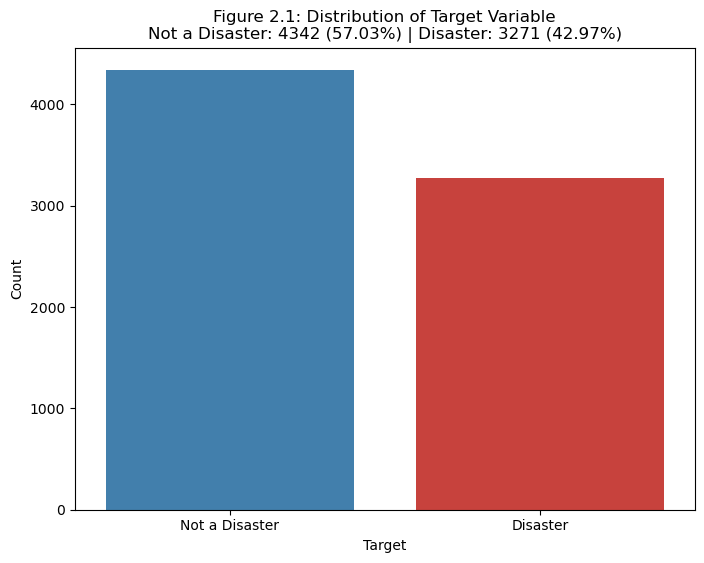

In [ ]:
# Calculate counts and percentages
target_counts = train_df['target'].value_counts()
total_tweets = target_counts.sum()
disaster_tweets = target_counts[1]
not_disaster_tweets = target_counts[0]
disaster_percentage = (disaster_tweets / total_tweets) * 100
not_disaster_percentage = (not_disaster_tweets / total_tweets) * 100

# Plotting target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df, palette={0: '#3182bd', 1: '#de2d26'})
plt.xlabel('Target')
plt.ylabel('Count')
plt.title(f'Figure 2.1: Distribution of Target Variable\nNot a Disaster: {not_disaster_tweets} ({not_disaster_percentage:.2f}%) | Disaster: {disaster_tweets} ({disaster_percentage:.2f}%)')
plt.xticks([0, 1], ['Not a Disaster', 'Disaster'])
plt.show()

## 2.2 Keyword vs Target Analysis

Analyzing the relationship between keywords and the target variable provides insights into the association between specific selected terms and disaster-related tweets:

<Figure size 1200x800 with 0 Axes>

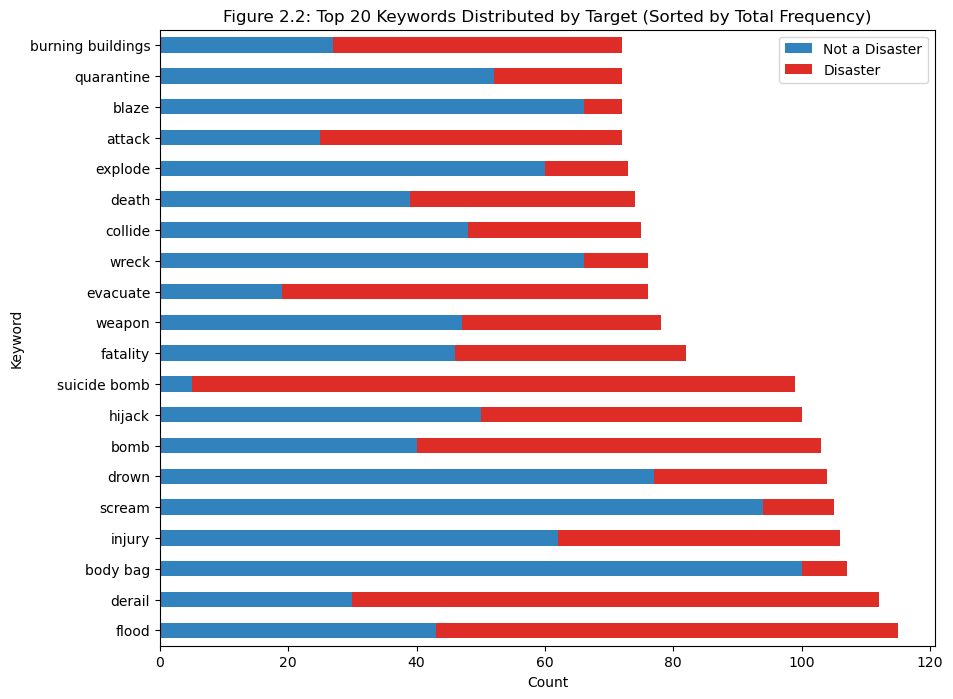

In [ ]:
# Group by 'keyword_cleaned' and 'target', then count the occurrences
keyword_target = train_df.groupby(['keyword_cleaned', 'target']).size().unstack(fill_value=0)
keyword_target.columns = ['Not a Disaster', 'Disaster']

# Calculate total frequency of each keyword
keyword_target['Total'] = keyword_target.sum(axis=1)

# Sort by total frequency in descending order and select top 20
keyword_target_sorted = keyword_target.sort_values(by='Total', ascending=False).head(20)

colors = ['#3182bd', '#de2d26']

# Plotting the sorted dataframe
plt.figure(figsize=(12, 8))
keyword_target_sorted.drop(columns='Total').plot(kind='barh', stacked=True, color=colors, figsize=(10, 8))
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Figure 2.2: Top 20 Keywords Distributed by Target (Sorted by Total Frequency)')
plt.legend(['Not a Disaster', 'Disaster'])
plt.show()

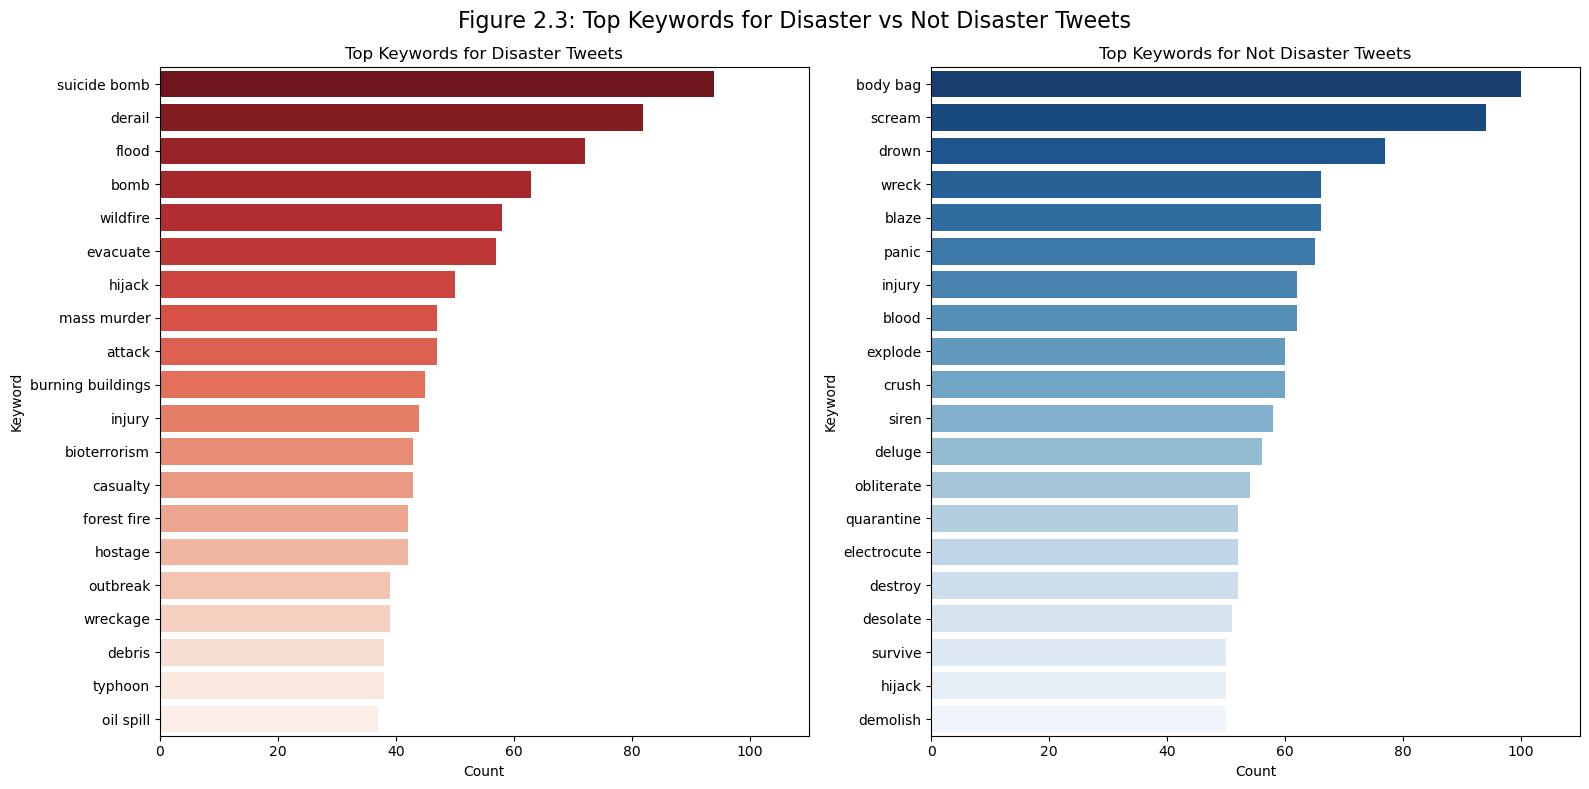

In [ ]:
# Group by 'keyword_cleaned' and 'target', then count the occurrences
keyword_target = train_df.groupby(['keyword_cleaned', 'target']).size().unstack(fill_value=0)

# Rename columns for better clarity
keyword_target.columns = ['Not a Disaster', 'Disaster']

# Create separate DataFrames for disaster and not disaster tweets
keyword_target_disaster = keyword_target[['Disaster']].reset_index()
keyword_target_not_disaster = keyword_target[['Not a Disaster']].reset_index()

# Sort keyword_target_disaster by counts of target=1 (disaster)
keyword_target_disaster_sorted = keyword_target_disaster.sort_values(by='Disaster', ascending=False).head(20)

# Sort keyword_target_not_disaster by counts of target=0 (not disaster)
keyword_target_not_disaster_sorted = keyword_target_not_disaster.sort_values(by='Not a Disaster', ascending=False).head(20)

# Plotting both dataframes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for disaster tweets
sns.barplot(x='Disaster', y='keyword_cleaned', data=keyword_target_disaster_sorted, palette='Reds_r', ax=ax1)
ax1.set_xlabel('Count')
ax1.set_ylabel('Keyword')
ax1.set_title('Top Keywords for Disaster Tweets')
ax1.set_xlim(0, 110)

# Plot for not disaster tweets
sns.barplot(x='Not a Disaster', y='keyword_cleaned', data=keyword_target_not_disaster_sorted, palette='Blues_r', ax=ax2)
ax2.set_xlabel('Count')
ax2.set_ylabel('Keyword')
ax2.set_title('Top Keywords for Not Disaster Tweets')
ax2.set_xlim(0, 110)

# Adding a super title
fig.suptitle('Figure 2.3: Top Keywords for Disaster vs Not Disaster Tweets', fontsize=16)

plt.tight_layout()
plt.show()

## 2.3 Location vs Target Analysis

Exploring the relationship between locations and the target variable helps understand geographical patterns in disaster-related tweets:

Figure 2.4 illustrates that the data locations are heavily skewed towards the United States. Both Figures 2.4 and 2.4 show that there are substantial differences between the use of locations and diaster versus not a disaster tweets.

<Figure size 1200x800 with 0 Axes>

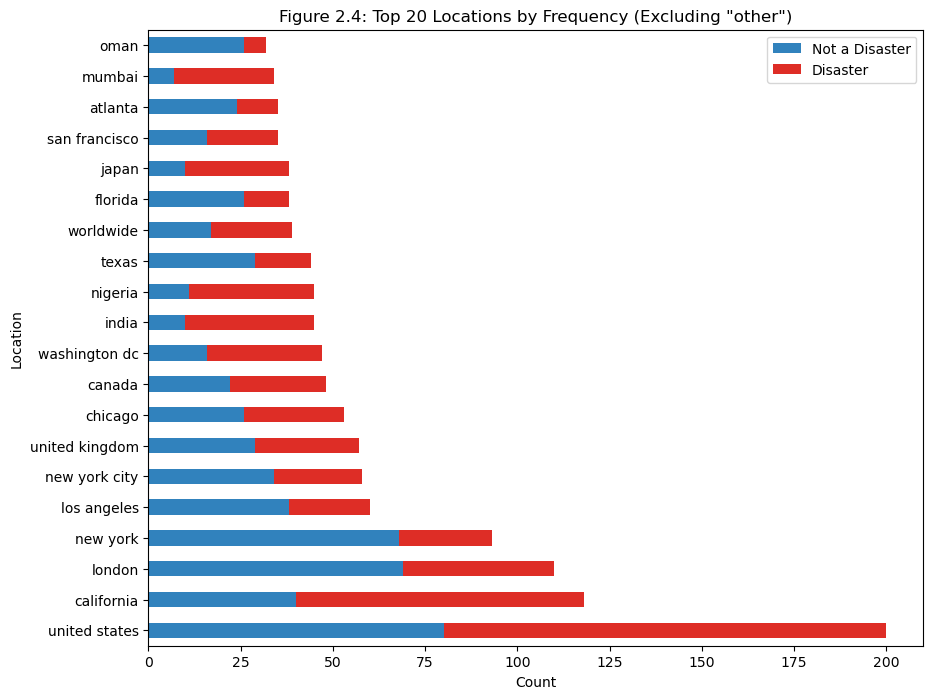

In [ ]:
# Group by 'location_cleaned' and 'target', then count the occurrences
location_target = train_df[train_df['location_cleaned'] != 'other'].groupby(['location_cleaned', 'target']).size().unstack(fill_value=0)

# Rename columns for better clarity
location_target.columns = ['Not a Disaster', 'Disaster']

# Calculate total frequency of each location
location_target['Total'] = location_target.sum(axis=1)

# Sort by total frequency in descending order and select top 20
location_target_sorted = location_target.sort_values(by='Total', ascending=False).head(20)

# Plotting the sorted dataframe
plt.figure(figsize=(12, 8))
location_target_sorted.drop(columns='Total').plot(kind='barh', stacked=True, color=colors, figsize=(10, 8))
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Figure 2.4: Top 20 Locations by Frequency (Excluding "other")')
plt.legend(['Not a Disaster', 'Disaster'])
plt.show()

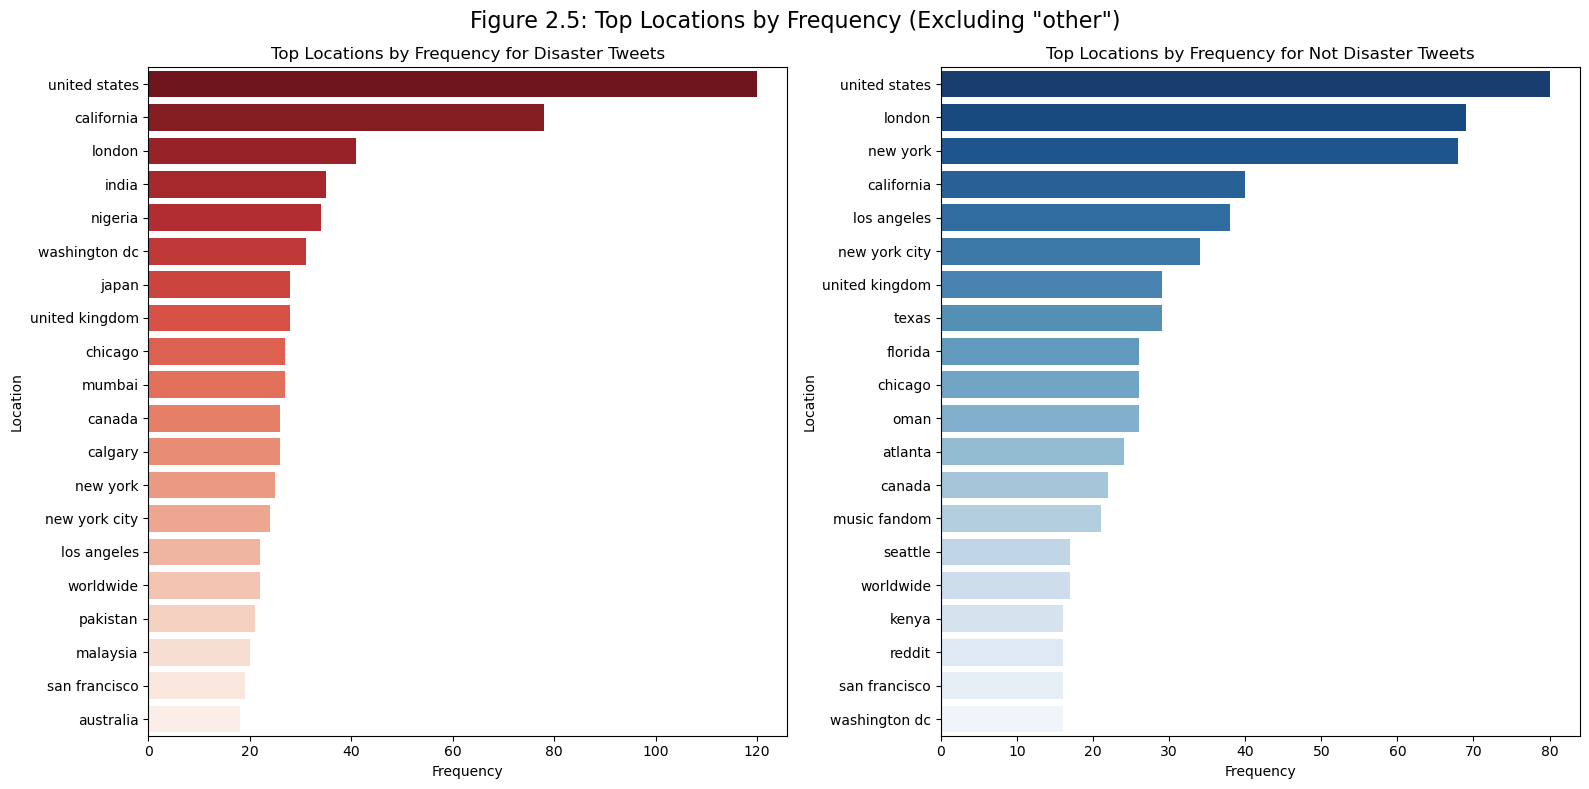

In [ ]:
# Filter out 'other' location category
top_locations = train_df[train_df['location_cleaned'] != 'other']

# Top locations by frequency for disaster tweets
top_locations_disaster = top_locations[top_locations['target'] == 1]['location_cleaned'].value_counts().head(20)

# Top locations by frequency for not disaster tweets
top_locations_not_disaster = top_locations[top_locations['target'] == 0]['location_cleaned'].value_counts().head(20)

# Plotting both dataframes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for disaster tweets
sns.barplot(x=top_locations_disaster.values, y=top_locations_disaster.index, palette='Reds_r', ax=ax1)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Location')
ax1.set_title('Top Locations by Frequency for Disaster Tweets')

# Plot for not disaster tweets
sns.barplot(x=top_locations_not_disaster.values, y=top_locations_not_disaster.index, palette='Blues_r', ax=ax2)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Location')
ax2.set_title('Top Locations by Frequency for Not Disaster Tweets')

# Adding a super title
fig.suptitle('Figure 2.5: Top Locations by Frequency (Excluding "other")', fontsize=16)

plt.tight_layout()
plt.show()

## 2.4 Text Vs Target

Analyzing the relationship between cleaned text features and the target variable provides insights into the textual characteristics of disaster-related tweets:



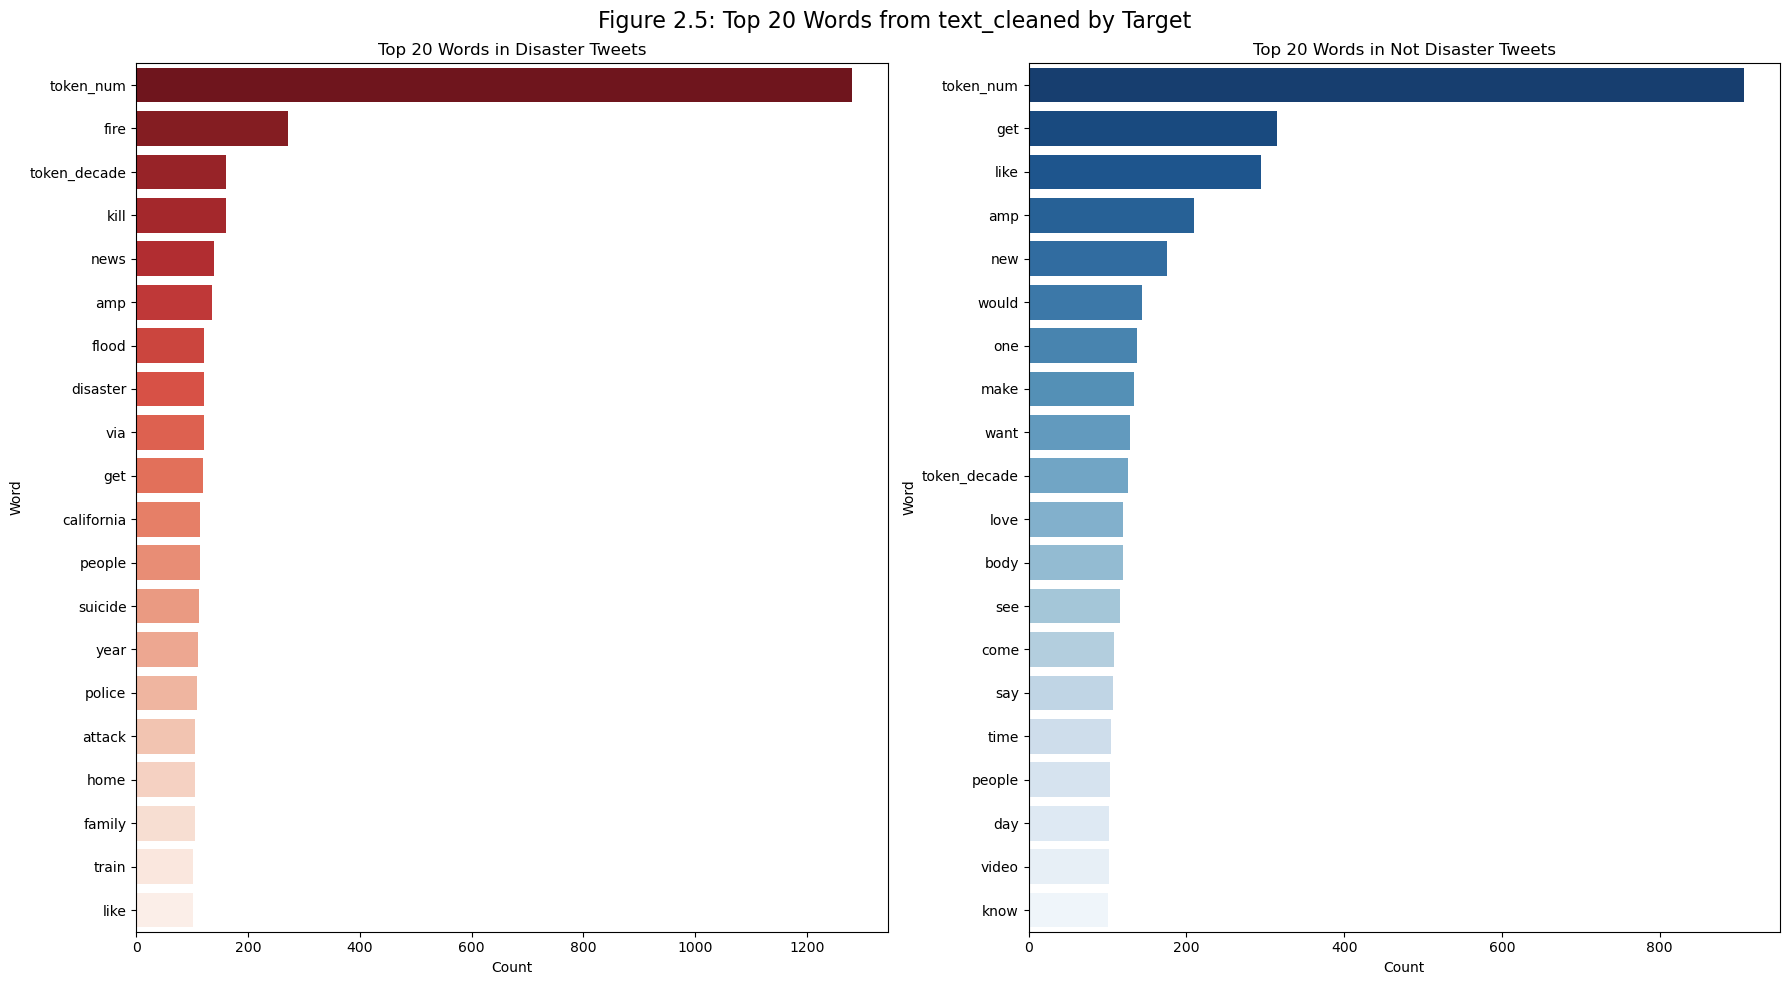

In [ ]:
# Function to filter tokens based on the criteria
def filter_tokens(tokens):
    filtered_tokens = [token for token in tokens if len(token) > 2 and (token.startswith("token_") or token.isalpha())]
    return filtered_tokens

# Function to clean and tokenize text
def clean_and_tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    tokens = filter_tokens(tokens)
    return tokens

# Combine text_cleaned strings into one
all_text = ' '.join(train_df['text_cleaned'].dropna())

# Tokenize and clean combined text
tokens = clean_and_tokenize(all_text)

# Count frequencies of each token by target
word_freq_disaster = Counter()
word_freq_not_disaster = Counter()

for index, row in train_df.iterrows():
    tokens = clean_and_tokenize(row['text_cleaned'])
    if row['target'] == 1:
        word_freq_disaster.update(tokens)
    else:
        word_freq_not_disaster.update(tokens)

# Select top 20 words by frequency for disaster and not disaster tweets
top_words_disaster = word_freq_disaster.most_common(20)
top_words_not_disaster = word_freq_not_disaster.most_common(20)

# Extract words and frequencies
words_disaster = [word for word, freq in top_words_disaster]
frequencies_disaster = [freq for word, freq in top_words_disaster]

words_not_disaster = [word for word, freq in top_words_not_disaster]
frequencies_not_disaster = [freq for word, freq in top_words_not_disaster]

# Plotting the top 20 words by frequency for disaster and not disaster tweets
plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=frequencies_disaster, y=words_disaster, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Words in Disaster Tweets')

plt.subplot(1, 2, 2)
sns.barplot(x=frequencies_not_disaster, y=words_not_disaster, palette='Blues_r')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Words in Not Disaster Tweets')

plt.suptitle('Figure 2.5: Top 20 Words from text_cleaned by Target', fontsize=16)
plt.tight_layout()
plt.show()

## 2.5 Feature Engineering

In the process of enhancing the predictive capability of the model, several key feature engineering strategies were implemented during the cleaning of text data (`text_cleaned`) and other relevant dataset attributes:

1. Tokenization

The `text_cleaned` column was tokenized to extract individual words, enabling the counting of word frequencies. This approach highlighted significant terms within tweets, aiding in distinguishing disaster-related content from non-disaster content.

2. Parts of Speech (POS) Tagging

Each word in the cleaned text was tagged with its corresponding part of speech using the NLTK library. This tagging facilitated more precise lemmatization, ensuring that words were reduced to their base forms appropriately based on their grammatical roles.

3. Location-Based Features:

Geographic patterns identified in the `location_cleaned` column were utilized to create indicators and categorical features representing prominent regions. This addition aimed to capture geographical influences on tweet content related to disasters.

The following code does the following futher feature engineering:

1. TF-IDF (Term Frequency-Inverse Document Frequency):

TF-IDF scores were computed to weigh the importance of tokens based on their frequency in tweets relative to their prevalence across all tweets. This method identified tokens that are particularly distinctive to disaster-related tweets, thereby enriching the feature set.

2. Normalization and Standardization

Numerical features such as text_len (length of cleaned text) and word_count (number of words in cleaned text) were normalized and standardized. Normalization ensured that these features were scaled to a range between 0 and 1, while standardization centered the data around zero with a standard deviation of one. These transformations ensured that numerical features had consistent scales and distributions, which is crucial for many machine learning algorithms.

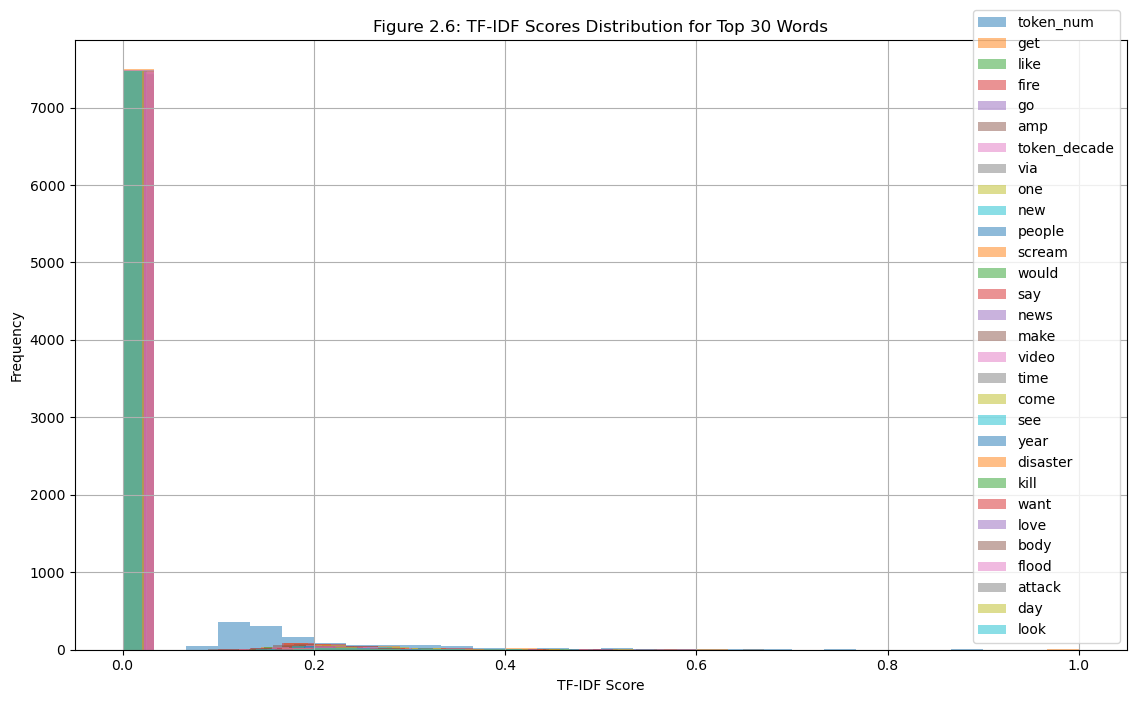

Selected words: ['token_num', 'get', 'like', 'fire', 'go', 'amp', 'token_decade', 'via', 'one', 'new', 'people', 'scream', 'would', 'say', 'news', 'make', 'video', 'time', 'come', 'see', 'year', 'disaster', 'kill', 'want', 'love', 'body', 'flood', 'attack', 'day', 'look']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler


# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit TF-IDF vectorizer on cleaned text in train and test datasets
tfidf_train = tfidf_vectorizer.fit_transform(train_df['text_cleaned'].values)
tfidf_test = tfidf_vectorizer.transform(test_df['text_cleaned'].values)

train_df['text_len'] = train_df['text_cleaned'].apply(lambda x: len(x.split()))
test_df['text_len'] = test_df['text_cleaned'].apply(lambda x: len(x.split()))

# Initialize MinMaxScaler for normalization
scaler = MinMaxScaler()

# Normalize numerical features: text_len and word_count
train_df['text_len'] = train_df['text_cleaned'].apply(lambda x: len(x.split()))
test_df['text_len'] = test_df['text_cleaned'].apply(lambda x: len(x.split()))

# Normalize text_len
train_df['text_len_normalized'] = scaler.fit_transform(train_df[['text_len']])
test_df['text_len_normalized'] = scaler.transform(test_df[['text_len']])

# Compute word count
train_df['word_count'] = train_df['text_cleaned'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text_cleaned'].apply(lambda x: len(x.split()))

# Normalize Word Count:
train_df['word_count_normalized'] = scaler.fit_transform(train_df[['word_count']])
test_df['word_count_normalized'] = scaler.transform(test_df[['word_count']])

# Example plot of TF-IDF scores for selected words
selected_words = []

# Extract TF-IDF scores from the vectorizer
tfidf_scores = tfidf_train.toarray()  # Assuming tfidf_train is your TF-IDF matrix

plt.figure(figsize=(12, 8))

# Choose top N words with highest average TF-IDF scores
N = 30
mean_tfidf_scores = tfidf_scores.mean(axis=0)  # Calculate mean TF-IDF score for each word
top_n_indices = mean_tfidf_scores.argsort()[-N:][::-1]  # Indices of top N words by mean TF-IDF score

feature_names = tfidf_vectorizer.get_feature_names_out()  # Get feature names from TfidfVectorizer

for index in top_n_indices:
    word = feature_names[index]
    selected_words.append(word)
    plt.hist(tfidf_scores[:, index], bins=30, alpha=0.5, label=word)

plt.title(f'Figure 2.6: TF-IDF Scores Distribution for Top {N} Words')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Increase padding and adjust rect
plt.show()

print("Selected words:", selected_words)

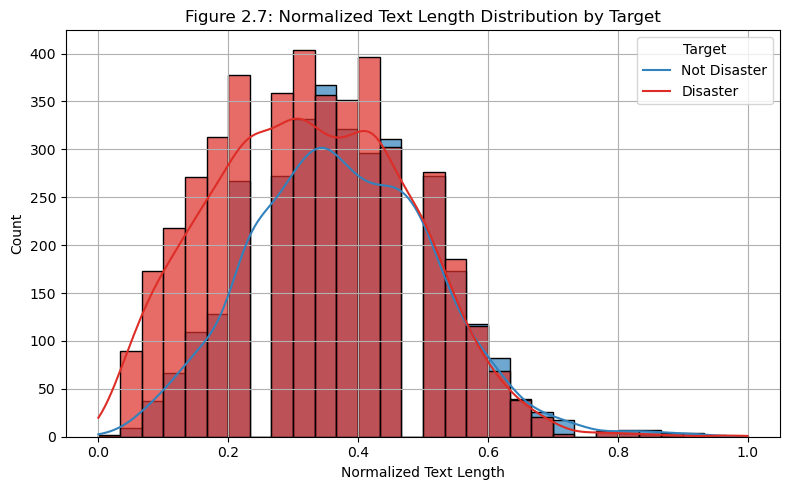

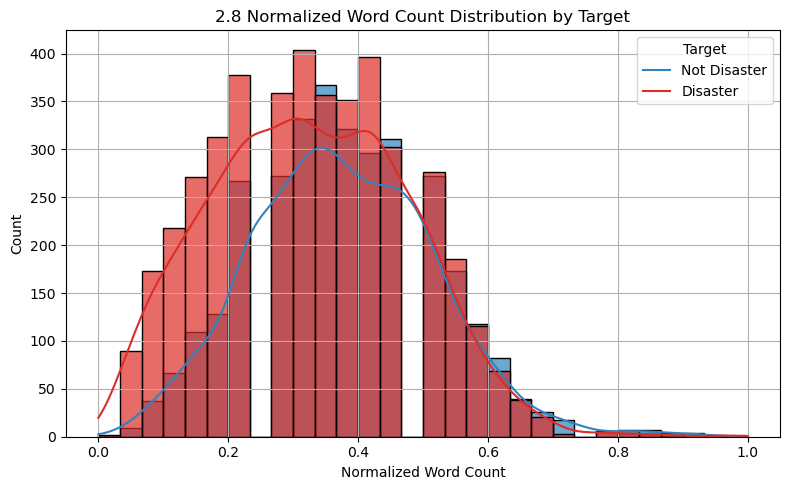

In [ ]:
# Define the colors for 'Disaster' and 'Not Disaster'
colors = ['#de2d26', '#3182bd']

plt.figure(figsize=(8, 5))

# Plotting the histogram with shaded KDE plots
sns.histplot(data=train_df, x='text_len_normalized', hue='target', kde=True, bins=30, alpha=0.7, palette=colors)
plt.title('Figure 2.7: Normalized Text Length Distribution by Target')
plt.xlabel('Normalized Text Length')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Not Disaster', 'Disaster'])
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

# Plot histogram with shaded KDE plots
sns.histplot(data=train_df, x='word_count_normalized', hue='target', kde=True, bins=30, alpha=0.7, palette=colors)
plt.title('2.8 Normalized Word Count Distribution by Target')
plt.xlabel('Normalized Word Count')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Not Disaster', 'Disaster'])
plt.grid(True)
plt.tight_layout()
plt.show()

# 3 Model Building

## 3.1 Preparing the Data for Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import numpy as np

# Split the dataset into training and validation sets (80% train, 20% validation)
X = train_df[['keyword_cleaned', 'location_cleaned', 'text_cleaned', 'text_len_normalized', 'word_count_normalized']]
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply TF-IDF vectorization to the text features
tfidf_vectorizer_keyword = TfidfVectorizer(max_features=5000)
tfidf_vectorizer_location = TfidfVectorizer(max_features=5000)
tfidf_vectorizer_text = TfidfVectorizer(max_features=5000)

# Apply TF-IDF to each text column for the train set
tfidf_keyword = tfidf_vectorizer_keyword.fit_transform(X_train['keyword_cleaned'])
tfidf_location = tfidf_vectorizer_location.fit_transform(X_train['location_cleaned'])
tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text_cleaned'])

# Normalize numerical features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train[['text_len_normalized', 'word_count_normalized']])

# Combine TF-IDF features and normalized features for the train set
X_train_combined = hstack([tfidf_keyword, tfidf_location, tfidf_text, X_train_normalized])

# Oversample using SMOTE
smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# Apply the same TF-IDF transformation to the validation set
tfidf_keyword_val = tfidf_vectorizer_keyword.transform(X_val['keyword_cleaned'])
tfidf_location_val = tfidf_vectorizer_location.transform(X_val['location_cleaned'])
tfidf_text_val = tfidf_vectorizer_text.transform(X_val['text_cleaned'])

X_val_normalized = scaler.transform(X_val[['text_len_normalized', 'word_count_normalized']])
X_val_combined = hstack([tfidf_keyword_val, tfidf_location_val, tfidf_text_val, X_val_normalized])

# For the test set, ensure it uses the same transformations
X_test = test_df[['keyword_cleaned', 'location_cleaned', 'text_cleaned', 'text_len_normalized', 'word_count_normalized']]
y_test = test_df['target']

tfidf_keyword_test = tfidf_vectorizer_keyword.transform(X_test['keyword_cleaned'])
tfidf_location_test = tfidf_vectorizer_location.transform(X_test['location_cleaned'])
tfidf_text_test = tfidf_vectorizer_text.transform(X_test['text_cleaned'])

X_test_normalized = scaler.transform(X_test[['text_len_normalized', 'word_count_normalized']])
X_test_combined = hstack([tfidf_keyword_test, tfidf_location_test, tfidf_text_test, X_test_normalized])

# Verify the shapes
print(f"Train Set Shape: {X_train_combined.shape}")
print(f"Validation Set Shape: {X_val_combined.shape}")
print(f"Test Set Shape: {X_test_combined.shape}")

# Verify class balance after SMOTE
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class Distribution in Train Set after SMOTE: {dict(zip(unique, counts))}")


Train Set Shape: (6946, 7457)
Validation Set Shape: (1523, 7457)
Test Set Shape: (3263, 7457)
Class Distribution in Train Set after SMOTE: {0: 3473, 1: 3473}


In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        assert X.shape[0] == len(y), f"Length mismatch: {X.shape[0]} vs {len(y)}"
        # Convert sparse matrix to dense tensor
        self.inputs = torch.tensor(X.toarray(), dtype=torch.float32)  # Convert sparse matrix to dense tensor
        self.targets = torch.tensor(y.values, dtype=torch.long)  # Ensure targets are also in tensor format

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_data = self.inputs[idx]  # Shape: (input_dim,)
        target_data = self.targets[idx]  # Shape: (1,)
        # Reshape input for LSTM (batch_size, seq_len, input_dim)
        input_data = input_data.unsqueeze(0)  # Shape: (seq_len=1, input_dim)
        return input_data, target_data

# Create the DataLoader for training, validation, and testing
train_dataset = TextDataset(X_train_combined, y_train)
val_dataset = TextDataset(X_val_combined, y_val)
test_dataset = TextDataset(X_test_combined, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
from torch.utils.data import DataLoader

# Save the datasets
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')

# Now create the DataLoaders and save their batch sizes
batch_size = 32  # Define the batch size you want for your DataLoaders
torch.save(batch_size, 'batch_size.pt')

In [ ]:
# Load the datasets
train_dataset = torch.load('train_dataset.pt')
val_dataset = torch.load('val_dataset.pt')
test_dataset = torch.load('test_dataset.pt')

# Load the batch size
batch_size = torch.load('batch_size.pt')

# Create the DataLoaders again using the loaded datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3.2 Model Architecture: LSTM Model

The LSTM model is designed for sequence-based prediction tasks. It uses a Long Short-Term Memory (LSTM) layer to capture dependencies over time, making it ideal for sequential data. The components are:

- LSTM Layer: The LSTM layer processes input sequences and retains important information across time steps, using its hidden and cell states.
- Fully Connected Layer: The last hidden state from the LSTM is passed through a fully connected layer to make predictions.
- Dropout: To avoid overfitting, apply a dropout rate after the LSTM and before the fully connected layer.

Input goes through the LSTM layer, then dropout is applied, and the output is passed to the fully connected layer for the final prediction.

In [ ]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_size)

        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)

        # Use the output of the last LSTM time step (last hidden state)
        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)

        # Pass through dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out

# Model hyperparameters section
hyperparameters = {
    'input_dim': X_train_combined.shape[1],  # Number of features (after TF-IDF + normalized features)
    'hidden_dim': 64,                       # Number of features in the hidden state
    'output_dim': 2,                        # Number of classes (adjust based on your problem)
    'num_layers': 2,                        # Number of LSTM layers
    'dropout_rate': 0.5,                    # Dropout rate for regularization
    'learning_rate': 0.001                  # Learning rate for optimizer
}

# Instantiate the model using the hyperparameters
model = LSTMModel(
    input_dim=hyperparameters['input_dim'],
    hidden_dim=hyperparameters['hidden_dim'],
    output_dim=hyperparameters['output_dim'],
    num_layers=hyperparameters['num_layers'],
    dropout_rate=hyperparameters['dropout_rate']
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])


In [ ]:
import pandas as pd

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="lstm1"):
    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_loss = val_loss / len(val_loader)

        # Save the data for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print the statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Return the saved data
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

# Train the model and save the data in variables
lstm1_data = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="lstm1")

# Access the data like this:
train_losses_lstm1 = lstm1_data['train_losses']
train_accuracies_lstm1 = lstm1_data['train_accuracies']
val_losses_lstm1 = lstm1_data['val_losses']
val_accuracies_lstm1 = lstm1_data['val_accuracies']


Epoch [1/10], Train Loss: 0.5901, Train Accuracy: 0.6818, Val Loss: 0.4487, Val Accuracy: 0.8070
Epoch [2/10], Train Loss: 0.3329, Train Accuracy: 0.8602, Val Loss: 0.4743, Val Accuracy: 0.7945
Epoch [3/10], Train Loss: 0.2165, Train Accuracy: 0.9126, Val Loss: 0.5680, Val Accuracy: 0.7715
Epoch [4/10], Train Loss: 0.1459, Train Accuracy: 0.9456, Val Loss: 0.6759, Val Accuracy: 0.7708
Epoch [5/10], Train Loss: 0.1006, Train Accuracy: 0.9630, Val Loss: 0.7811, Val Accuracy: 0.7787
Epoch [6/10], Train Loss: 0.0791, Train Accuracy: 0.9718, Val Loss: 0.9244, Val Accuracy: 0.7669
Epoch [7/10], Train Loss: 0.0616, Train Accuracy: 0.9774, Val Loss: 1.0112, Val Accuracy: 0.7610
Epoch [8/10], Train Loss: 0.0525, Train Accuracy: 0.9807, Val Loss: 1.0415, Val Accuracy: 0.7781
Epoch [9/10], Train Loss: 0.0432, Train Accuracy: 0.9850, Val Loss: 1.1946, Val Accuracy: 0.7413
Epoch [10/10], Train Loss: 0.0380, Train Accuracy: 0.9853, Val Loss: 1.2019, Val Accuracy: 0.7610


# 4 Results and Analysis

## 4.1 Hyperparameter Tuning

Hyperparameter tuning is essential for optimizing the performance of machine learning models. It involves systematically exploring combinations of key parameters to determine the configuration that produces the best results for the task at hand. For this project, the hyperparameter tuning process focuses on the following parameters for the LSTM model:

Hidden Dimension (hidden_dim): Determines the number of features in the hidden state of the LSTM. Larger dimensions allow the model to capture more information but increase computational complexity and the risk of overfitting.

Number of LSTM Layers (num_layers): Specifies the number of stacked LSTM layers in the model. Increasing this value allows the model to capture more complex relationships in the data but may also lead to higher training time and potential overfitting.

Dropout Rate (dropout_rate): A regularization technique that helps mitigate overfitting by randomly dropping a fraction of neurons during training. Testing different rates identifies the balance between generalization and performance.

Learning Rate (learning_rate): Controls the step size during gradient updates in the optimization process. A well-tuned learning rate ensures convergence while avoiding instability or excessively slow training.

A grid search approach is used to systematically explore combinations of these parameters. The search space includes:

- Hidden Dimensions: [32, 64, 128, 256]
- Number of Layers: [1, 2, 3, 4]
- Dropout Rates: [0.3, 0.5, 0.7]
- Learning Rates: [0.001, 0.005, 0.01]

For each combination of parameters, the LSTM model is trained and evaluated using the following metrics:

- Training Loss: Measures the model's fit on the training data.
- Validation Loss: Assesses how well the model generalizes to unseen data.
- Validation Accuracy: Represents the percentage of correctly classified samples on the validation set.

The training process involves recording these metrics for every epoch to monitor model performance and generalization trends. Each model configuration is saved at the end of training to facilitate comparisons and potential reuse.

The results are stored and analyzed to identify the hyperparameter combination that yields the best balance between validation loss and accuracy. This systematic exploration ensures the LSTM model achieves optimal performance for the specific task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from itertools import product

# Model definition with Batch Normalization
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state

        # Batch Normalization
        lstm_out = self.batch_norm(lstm_out)

        # Dropout regularization
        out = self.dropout(lstm_out)

        # Fully connected layer
        out = self.fc(out)
        return out


# Function to train the model with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="model", patience=5):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_path = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = f"{model_name}_best.pth"
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model to {best_model_path}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # If no improvement for `patience` epochs, stop training
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs due to no improvement in validation loss.")
            break

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'best_model_path': best_model_path
    }


# Define hyperparameters to test
hyperparameters = {
    'input_dim': X_train_combined.shape[1],  # Number of features
    'output_dim': 2,                        # Number of classes
    'hidden_dims': [32, 64, 128, 256],      # Hidden layer dimensions
    'num_layers': [1, 2, 3, 4],             # Number of LSTM layers
    'dropout_rates': [0.3, 0.5, 0.7],       # Dropout rates
    'learning_rates': [0.001, 0.005, 0.01], # Learning rates
}

# Initialize a list to store the results
epoch_results = []

# Training models with different hyperparameter combinations
for hidden_dim, num_layers, dropout_rate, learning_rate in product(
    hyperparameters['hidden_dims'],
    hyperparameters['num_layers'],
    hyperparameters['dropout_rates'],
    hyperparameters['learning_rates']
):
    # Create a unique model name based on the hyperparameters
    model_name = f"lstm_h{hidden_dim}_l{num_layers}_lr{learning_rate}_dr{dropout_rate}"
    model_best_path = f"{model_name}_best.pth"

    # Check if the model already exists
    if os.path.exists(model_best_path):
        print(f"Model {model_name} already exists. Skipping training.")
        print(f"Loading the model from {model_best_path}.")

        # Optionally, load the model
        model = LSTMModel(
            input_dim=hyperparameters['input_dim'],
            hidden_dim=hidden_dim,
            output_dim=hyperparameters['output_dim'],
            num_layers=num_layers,
            dropout_rate=dropout_rate
        )
        model.load_state_dict(torch.load(model_best_path))

        # Print the loaded model information
        print(f"Loaded Model Info for {model_name}:")
        print(f"Hidden Dim: {hidden_dim}, Num Layers: {num_layers}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
        print(f"Validation loss for the best model: {model_best_path}")

    else:
        print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}, dropout_rate={dropout_rate}, lr={learning_rate}")

        model = LSTMModel(
            input_dim=hyperparameters['input_dim'],
            hidden_dim=hidden_dim,
            output_dim=hyperparameters['output_dim'],
            num_layers=num_layers,
            dropout_rate=dropout_rate
        )

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        training_results = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            num_epochs=10,
            model_name=model_name,
            patience=5
        )

        # Store the results at the epoch level
        for epoch_idx, (train_loss, val_loss, val_accuracy) in enumerate(zip(
            training_results['train_loss'],
            training_results['val_loss'],
            training_results['val_accuracy']
        )):
            epoch_results.append({
                'hidden_dim': hidden_dim,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'learning_rate': learning_rate,
                'epoch': epoch_idx + 1,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            })

        print(f"Finished training for hidden_dim={hidden_dim}, num_layers={num_layers}, dropout_rate={dropout_rate}, lr={learning_rate}")

# Convert the epoch-level results into a DataFrame
df_epoch_results = pd.DataFrame(epoch_results)

# Save the epoch-level results DataFrame as CSV
df_epoch_results.to_csv("model_results.csv", index=False)


Training model with hidden_dim=32, num_layers=1, dropout_rate=0.3, lr=0.001
Epoch [1/10], Train Loss: 0.5774, Train Accuracy: 0.6975, Val Loss: 0.4716, Val Accuracy: 0.7932
Saved best model to lstm_h32_l1_lr0.001_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.3763, Train Accuracy: 0.8363, Val Loss: 0.4708, Val Accuracy: 0.7886
Saved best model to lstm_h32_l1_lr0.001_dr0.3_best.pth
Epoch [3/10], Train Loss: 0.2704, Train Accuracy: 0.8878, Val Loss: 0.5118, Val Accuracy: 0.7859
Epoch [4/10], Train Loss: 0.2064, Train Accuracy: 0.9200, Val Loss: 0.5798, Val Accuracy: 0.7735
Epoch [5/10], Train Loss: 0.1665, Train Accuracy: 0.9331, Val Loss: 0.6260, Val Accuracy: 0.7853
Epoch [6/10], Train Loss: 0.1359, Train Accuracy: 0.9498, Val Loss: 0.6473, Val Accuracy: 0.7682
Epoch [7/10], Train Loss: 0.1209, Train Accuracy: 0.9593, Val Loss: 0.7422, Val Accuracy: 0.7610
Early stopping after 7 epochs due to no improvement in validation loss.
Finished training for hidden_dim=32, num_layers=1, dropout_rate

Epoch [6/10], Train Loss: 0.2136, Train Accuracy: 0.9192, Val Loss: 0.5828, Val Accuracy: 0.7846
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=32, num_layers=1, dropout_rate=0.7, lr=0.01
Training model with hidden_dim=32, num_layers=2, dropout_rate=0.3, lr=0.001
Epoch [1/10], Train Loss: 0.5683, Train Accuracy: 0.6954, Val Loss: 0.4680, Val Accuracy: 0.7951
Saved best model to lstm_h32_l2_lr0.001_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.3511, Train Accuracy: 0.8483, Val Loss: 0.4885, Val Accuracy: 0.7859
Epoch [3/10], Train Loss: 0.2266, Train Accuracy: 0.9105, Val Loss: 0.6132, Val Accuracy: 0.7722
Epoch [4/10], Train Loss: 0.1631, Train Accuracy: 0.9395, Val Loss: 0.7179, Val Accuracy: 0.7571
Epoch [5/10], Train Loss: 0.1291, Train Accuracy: 0.9568, Val Loss: 0.7819, Val Accuracy: 0.7741
Epoch [6/10], Train Loss: 0.1069, Train Accuracy: 0.9629, Val Loss: 0.9244, Val Accuracy: 0.7459
Early stopping after 6 epochs due to no i

Epoch [1/10], Train Loss: 0.5400, Train Accuracy: 0.7242, Val Loss: 0.4506, Val Accuracy: 0.8050
Saved best model to lstm_h32_l3_lr0.001_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.3193, Train Accuracy: 0.8697, Val Loss: 0.4890, Val Accuracy: 0.8056
Epoch [3/10], Train Loss: 0.2054, Train Accuracy: 0.9221, Val Loss: 0.5871, Val Accuracy: 0.7643
Epoch [4/10], Train Loss: 0.1527, Train Accuracy: 0.9437, Val Loss: 0.6891, Val Accuracy: 0.7774
Epoch [5/10], Train Loss: 0.1163, Train Accuracy: 0.9601, Val Loss: 0.7504, Val Accuracy: 0.7551
Epoch [6/10], Train Loss: 0.0995, Train Accuracy: 0.9637, Val Loss: 0.8622, Val Accuracy: 0.7544
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=32, num_layers=3, dropout_rate=0.3, lr=0.001
Training model with hidden_dim=32, num_layers=3, dropout_rate=0.3, lr=0.005
Epoch [1/10], Train Loss: 0.4959, Train Accuracy: 0.7617, Val Loss: 0.4369, Val Accuracy: 0.8096
Saved best model to lstm_h32_l3_lr0.005_

Epoch [4/10], Train Loss: 0.1460, Train Accuracy: 0.9475, Val Loss: 0.6954, Val Accuracy: 0.7630
Epoch [5/10], Train Loss: 0.1174, Train Accuracy: 0.9574, Val Loss: 0.8624, Val Accuracy: 0.7406
Epoch [6/10], Train Loss: 0.0995, Train Accuracy: 0.9653, Val Loss: 0.9388, Val Accuracy: 0.7682
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=32, num_layers=4, dropout_rate=0.3, lr=0.001
Training model with hidden_dim=32, num_layers=4, dropout_rate=0.3, lr=0.005
Epoch [1/10], Train Loss: 0.4966, Train Accuracy: 0.7663, Val Loss: 0.4655, Val Accuracy: 0.7971
Saved best model to lstm_h32_l4_lr0.005_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.2716, Train Accuracy: 0.8887, Val Loss: 0.7394, Val Accuracy: 0.6592
Epoch [3/10], Train Loss: 0.1759, Train Accuracy: 0.9345, Val Loss: 0.6961, Val Accuracy: 0.7163
Epoch [4/10], Train Loss: 0.1280, Train Accuracy: 0.9529, Val Loss: 0.7374, Val Accuracy: 0.7656
Epoch [5/10], Train Loss: 0.1044, Train 

Epoch [6/10], Train Loss: 0.1246, Train Accuracy: 0.9548, Val Loss: 0.7943, Val Accuracy: 0.7544
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=64, num_layers=1, dropout_rate=0.3, lr=0.001
Training model with hidden_dim=64, num_layers=1, dropout_rate=0.3, lr=0.005
Epoch [1/10], Train Loss: 0.4931, Train Accuracy: 0.7619, Val Loss: 0.4580, Val Accuracy: 0.8070
Saved best model to lstm_h64_l1_lr0.005_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.2820, Train Accuracy: 0.8871, Val Loss: 0.5133, Val Accuracy: 0.7971
Epoch [3/10], Train Loss: 0.1874, Train Accuracy: 0.9269, Val Loss: 0.6843, Val Accuracy: 0.7617
Epoch [4/10], Train Loss: 0.1416, Train Accuracy: 0.9473, Val Loss: 0.6872, Val Accuracy: 0.7781
Epoch [5/10], Train Loss: 0.1125, Train Accuracy: 0.9591, Val Loss: 0.7904, Val Accuracy: 0.7479
Epoch [6/10], Train Loss: 0.1026, Train Accuracy: 0.9659, Val Loss: 0.8287, Val Accuracy: 0.7439
Early stopping after 6 epochs due to no 

Epoch [1/10], Train Loss: 0.4873, Train Accuracy: 0.7702, Val Loss: 0.4841, Val Accuracy: 0.7984
Saved best model to lstm_h64_l2_lr0.005_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.2767, Train Accuracy: 0.8906, Val Loss: 0.5390, Val Accuracy: 0.7820
Epoch [3/10], Train Loss: 0.1862, Train Accuracy: 0.9332, Val Loss: 0.6445, Val Accuracy: 0.7761
Epoch [4/10], Train Loss: 0.1491, Train Accuracy: 0.9457, Val Loss: 0.7573, Val Accuracy: 0.7229
Epoch [5/10], Train Loss: 0.1073, Train Accuracy: 0.9633, Val Loss: 0.8738, Val Accuracy: 0.7676
Epoch [6/10], Train Loss: 0.0786, Train Accuracy: 0.9724, Val Loss: 0.9249, Val Accuracy: 0.7761
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=64, num_layers=2, dropout_rate=0.3, lr=0.005
Training model with hidden_dim=64, num_layers=2, dropout_rate=0.3, lr=0.01
Epoch [1/10], Train Loss: 0.4927, Train Accuracy: 0.7697, Val Loss: 0.4542, Val Accuracy: 0.7958
Saved best model to lstm_h64_l2_lr0.01_dr

Epoch [5/10], Train Loss: 0.1030, Train Accuracy: 0.9653, Val Loss: 0.8427, Val Accuracy: 0.7466
Epoch [6/10], Train Loss: 0.0810, Train Accuracy: 0.9714, Val Loss: 1.2038, Val Accuracy: 0.7367
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=64, num_layers=3, dropout_rate=0.3, lr=0.005
Training model with hidden_dim=64, num_layers=3, dropout_rate=0.3, lr=0.01
Epoch [1/10], Train Loss: 0.4940, Train Accuracy: 0.7672, Val Loss: 0.4787, Val Accuracy: 0.8050
Saved best model to lstm_h64_l3_lr0.01_dr0.3_best.pth
Epoch [2/10], Train Loss: 0.2721, Train Accuracy: 0.8890, Val Loss: 0.4901, Val Accuracy: 0.7807
Epoch [3/10], Train Loss: 0.1733, Train Accuracy: 0.9367, Val Loss: 0.5892, Val Accuracy: 0.7544
Epoch [4/10], Train Loss: 0.1199, Train Accuracy: 0.9568, Val Loss: 0.7988, Val Accuracy: 0.7866
Epoch [5/10], Train Loss: 0.1297, Train Accuracy: 0.9541, Val Loss: 0.7370, Val Accuracy: 0.7610
Epoch [6/10], Train Loss: 0.0686, Train Ac

Epoch [2/10], Train Loss: 0.2689, Train Accuracy: 0.8910, Val Loss: 0.5013, Val Accuracy: 0.7708
Saved best model to lstm_h64_l4_lr0.01_dr0.3_best.pth
Epoch [3/10], Train Loss: 0.1748, Train Accuracy: 0.9303, Val Loss: 0.7132, Val Accuracy: 0.7715
Epoch [4/10], Train Loss: 0.1129, Train Accuracy: 0.9574, Val Loss: 1.0430, Val Accuracy: 0.7275
Epoch [5/10], Train Loss: 0.0969, Train Accuracy: 0.9656, Val Loss: 0.9222, Val Accuracy: 0.7663
Epoch [6/10], Train Loss: 0.0650, Train Accuracy: 0.9755, Val Loss: 1.0822, Val Accuracy: 0.7630
Epoch [7/10], Train Loss: 0.0604, Train Accuracy: 0.9801, Val Loss: 0.9983, Val Accuracy: 0.7728
Early stopping after 7 epochs due to no improvement in validation loss.
Finished training for hidden_dim=64, num_layers=4, dropout_rate=0.3, lr=0.01
Training model with hidden_dim=64, num_layers=4, dropout_rate=0.5, lr=0.001
Epoch [1/10], Train Loss: 0.5155, Train Accuracy: 0.7414, Val Loss: 0.4673, Val Accuracy: 0.8076
Saved best model to lstm_h64_l4_lr0.001_dr

Epoch [4/10], Train Loss: 0.1485, Train Accuracy: 0.9447, Val Loss: 0.7122, Val Accuracy: 0.7689
Epoch [5/10], Train Loss: 0.1139, Train Accuracy: 0.9639, Val Loss: 0.7302, Val Accuracy: 0.7827
Epoch [6/10], Train Loss: 0.1074, Train Accuracy: 0.9607, Val Loss: 0.7703, Val Accuracy: 0.7820
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=128, num_layers=1, dropout_rate=0.3, lr=0.01
Training model with hidden_dim=128, num_layers=1, dropout_rate=0.5, lr=0.001
Epoch [1/10], Train Loss: 0.5413, Train Accuracy: 0.7267, Val Loss: 0.4492, Val Accuracy: 0.8011
Saved best model to lstm_h128_l1_lr0.001_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.3417, Train Accuracy: 0.8537, Val Loss: 0.4774, Val Accuracy: 0.8030
Epoch [3/10], Train Loss: 0.2493, Train Accuracy: 0.8991, Val Loss: 0.5503, Val Accuracy: 0.7919
Epoch [4/10], Train Loss: 0.1901, Train Accuracy: 0.9241, Val Loss: 0.6071, Val Accuracy: 0.7741
Epoch [5/10], Train Loss: 0.1669, Trai

Epoch [1/10], Train Loss: 0.5190, Train Accuracy: 0.7419, Val Loss: 0.4649, Val Accuracy: 0.7866
Saved best model to lstm_h128_l2_lr0.001_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.2968, Train Accuracy: 0.8775, Val Loss: 0.5209, Val Accuracy: 0.7728
Epoch [3/10], Train Loss: 0.2077, Train Accuracy: 0.9220, Val Loss: 0.6356, Val Accuracy: 0.7695
Epoch [4/10], Train Loss: 0.1515, Train Accuracy: 0.9463, Val Loss: 0.7309, Val Accuracy: 0.7768
Epoch [5/10], Train Loss: 0.1276, Train Accuracy: 0.9544, Val Loss: 0.8064, Val Accuracy: 0.7577
Epoch [6/10], Train Loss: 0.1153, Train Accuracy: 0.9613, Val Loss: 0.8427, Val Accuracy: 0.7748
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=128, num_layers=2, dropout_rate=0.5, lr=0.001
Training model with hidden_dim=128, num_layers=2, dropout_rate=0.5, lr=0.005
Epoch [1/10], Train Loss: 0.5019, Train Accuracy: 0.7676, Val Loss: 0.4840, Val Accuracy: 0.7820
Saved best model to lstm_h128_l2_lr0.

Epoch [2/10], Train Loss: 0.2937, Train Accuracy: 0.8792, Val Loss: 0.5177, Val Accuracy: 0.7853
Epoch [3/10], Train Loss: 0.2002, Train Accuracy: 0.9230, Val Loss: 0.5968, Val Accuracy: 0.7774
Epoch [4/10], Train Loss: 0.1556, Train Accuracy: 0.9421, Val Loss: 0.7801, Val Accuracy: 0.7676
Epoch [5/10], Train Loss: 0.1245, Train Accuracy: 0.9577, Val Loss: 0.7715, Val Accuracy: 0.7413
Epoch [6/10], Train Loss: 0.1136, Train Accuracy: 0.9618, Val Loss: 0.8818, Val Accuracy: 0.7636
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=128, num_layers=3, dropout_rate=0.5, lr=0.001
Training model with hidden_dim=128, num_layers=3, dropout_rate=0.5, lr=0.005
Epoch [1/10], Train Loss: 0.4969, Train Accuracy: 0.7688, Val Loss: 0.4804, Val Accuracy: 0.7951
Saved best model to lstm_h128_l3_lr0.005_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.2923, Train Accuracy: 0.8821, Val Loss: 0.5675, Val Accuracy: 0.7938
Epoch [3/10], Train Loss: 0.1907, Tra

Epoch [4/10], Train Loss: 0.1608, Train Accuracy: 0.9418, Val Loss: 0.7247, Val Accuracy: 0.7577
Epoch [5/10], Train Loss: 0.1240, Train Accuracy: 0.9557, Val Loss: 0.7770, Val Accuracy: 0.7531
Epoch [6/10], Train Loss: 0.1095, Train Accuracy: 0.9631, Val Loss: 0.9468, Val Accuracy: 0.7367
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=128, num_layers=4, dropout_rate=0.5, lr=0.001
Training model with hidden_dim=128, num_layers=4, dropout_rate=0.5, lr=0.005
Epoch [1/10], Train Loss: 0.4957, Train Accuracy: 0.7702, Val Loss: 0.4438, Val Accuracy: 0.8135
Saved best model to lstm_h128_l4_lr0.005_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.2857, Train Accuracy: 0.8897, Val Loss: 0.6408, Val Accuracy: 0.7045
Epoch [3/10], Train Loss: 0.1929, Train Accuracy: 0.9254, Val Loss: 0.6725, Val Accuracy: 0.7735
Epoch [4/10], Train Loss: 0.1400, Train Accuracy: 0.9463, Val Loss: 0.7788, Val Accuracy: 0.7439
Epoch [5/10], Train Loss: 0.1074, Tra

Epoch [1/10], Train Loss: 0.5512, Train Accuracy: 0.7436, Val Loss: 0.4636, Val Accuracy: 0.7912
Saved best model to lstm_h256_l1_lr0.005_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.3424, Train Accuracy: 0.8628, Val Loss: 0.5388, Val Accuracy: 0.7814
Epoch [3/10], Train Loss: 0.2475, Train Accuracy: 0.9037, Val Loss: 0.6036, Val Accuracy: 0.7840
Epoch [4/10], Train Loss: 0.2000, Train Accuracy: 0.9250, Val Loss: 0.6635, Val Accuracy: 0.7800
Epoch [5/10], Train Loss: 0.1666, Train Accuracy: 0.9368, Val Loss: 0.7741, Val Accuracy: 0.7617
Epoch [6/10], Train Loss: 0.1467, Train Accuracy: 0.9512, Val Loss: 0.7905, Val Accuracy: 0.7610
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=256, num_layers=1, dropout_rate=0.5, lr=0.005
Training model with hidden_dim=256, num_layers=1, dropout_rate=0.5, lr=0.01
Epoch [1/10], Train Loss: 0.5909, Train Accuracy: 0.7413, Val Loss: 0.4967, Val Accuracy: 0.7938
Saved best model to lstm_h256_l1_lr0.0

Epoch [5/10], Train Loss: 0.1157, Train Accuracy: 0.9574, Val Loss: 0.8909, Val Accuracy: 0.7748
Epoch [6/10], Train Loss: 0.1019, Train Accuracy: 0.9663, Val Loss: 0.8391, Val Accuracy: 0.7538
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=256, num_layers=2, dropout_rate=0.5, lr=0.005
Training model with hidden_dim=256, num_layers=2, dropout_rate=0.5, lr=0.01
Epoch [1/10], Train Loss: 0.5589, Train Accuracy: 0.7413, Val Loss: 0.4879, Val Accuracy: 0.7656
Saved best model to lstm_h256_l2_lr0.01_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.2891, Train Accuracy: 0.8874, Val Loss: 0.5723, Val Accuracy: 0.7820
Epoch [3/10], Train Loss: 0.1900, Train Accuracy: 0.9261, Val Loss: 0.7632, Val Accuracy: 0.7814
Epoch [4/10], Train Loss: 0.1316, Train Accuracy: 0.9513, Val Loss: 0.8552, Val Accuracy: 0.7689
Epoch [5/10], Train Loss: 0.1091, Train Accuracy: 0.9595, Val Loss: 0.8605, Val Accuracy: 0.7722
Epoch [6/10], Train Loss: 0.0747, Train

Epoch [1/10], Train Loss: 0.5482, Train Accuracy: 0.7449, Val Loss: 0.4917, Val Accuracy: 0.7991
Saved best model to lstm_h256_l3_lr0.01_dr0.5_best.pth
Epoch [2/10], Train Loss: 0.3096, Train Accuracy: 0.8778, Val Loss: 0.5706, Val Accuracy: 0.7728
Epoch [3/10], Train Loss: 0.2050, Train Accuracy: 0.9248, Val Loss: 0.6180, Val Accuracy: 0.7899
Epoch [4/10], Train Loss: 0.1326, Train Accuracy: 0.9503, Val Loss: 0.9481, Val Accuracy: 0.7426
Epoch [5/10], Train Loss: 0.1136, Train Accuracy: 0.9611, Val Loss: 0.7745, Val Accuracy: 0.7380
Epoch [6/10], Train Loss: 0.1162, Train Accuracy: 0.9618, Val Loss: 0.9060, Val Accuracy: 0.7866
Early stopping after 6 epochs due to no improvement in validation loss.
Finished training for hidden_dim=256, num_layers=3, dropout_rate=0.5, lr=0.01
Training model with hidden_dim=256, num_layers=3, dropout_rate=0.7, lr=0.001
Epoch [1/10], Train Loss: 0.4951, Train Accuracy: 0.7589, Val Loss: 0.4464, Val Accuracy: 0.8063
Saved best model to lstm_h256_l3_lr0.00

Epoch [5/10], Train Loss: 0.2137, Train Accuracy: 0.9263, Val Loss: 0.5540, Val Accuracy: 0.7781
Epoch [6/10], Train Loss: 0.1857, Train Accuracy: 0.9374, Val Loss: 0.7458, Val Accuracy: 0.7741
Epoch [7/10], Train Loss: 0.1414, Train Accuracy: 0.9513, Val Loss: 0.8623, Val Accuracy: 0.7656
Epoch [8/10], Train Loss: 0.0999, Train Accuracy: 0.9644, Val Loss: 0.9634, Val Accuracy: 0.7708
Early stopping after 8 epochs due to no improvement in validation loss.
Finished training for hidden_dim=256, num_layers=4, dropout_rate=0.5, lr=0.01
Training model with hidden_dim=256, num_layers=4, dropout_rate=0.7, lr=0.001
Epoch [1/10], Train Loss: 0.4949, Train Accuracy: 0.7661, Val Loss: 0.6984, Val Accuracy: 0.6743
Saved best model to lstm_h256_l4_lr0.001_dr0.7_best.pth
Epoch [2/10], Train Loss: 0.2968, Train Accuracy: 0.8771, Val Loss: 0.7326, Val Accuracy: 0.7912
Epoch [3/10], Train Loss: 0.2119, Train Accuracy: 0.9185, Val Loss: 0.6423, Val Accuracy: 0.7820
Saved best model to lstm_h256_l4_lr0.0

## 4.2 Model Performance Based on Hyperparameter Comparison

This section compares the performance of various models by exploring the impact of different hyperparameters on the LSTM model’s performance. Hyperparameters such as hidden dimensions, the number of LSTM layers, dropout rate, and learning rate were tuned and tested to assess their effects on model accuracy and loss.

### Hyperparameters Tested:

The following hyperparameters were tested:

Hidden Dimensions: 32, 64, 128, 256
Number of LSTM Layers: 1, 2, 3, 4
Dropout Rates: 0.3, 0.5, 0.7
Learning Rates: 0.001, 0.005, 0.01

A total of 144 unique hyperparameter combinations were tested across multiple epochs.

Validation Accuracy Summary Statistics:

The validation accuracy across all hyperparameter combinations had the following summary statistics:

In [ ]:
import pandas as pd

df_epoch_results = pd.read_csv("model_results.csv")

In [ ]:
# Summary statistics for validation accuracies
val_accuracy_summary = df_epoch_results["val_accuracy"].describe()

val_accuracy_summary

count    887.000000
mean       0.772461
std        0.025479
min        0.552856
25%        0.761655
50%        0.774787
75%        0.788575
max        0.818779
Name: val_accuracy, dtype: float64

### Training and Validation Loss:

The relationship between training and validation loss is visualized to understand overfitting and generalization trends. The observation that training loss decreases while validation loss increases as epochs progress suggests a classic sign of overfitting.

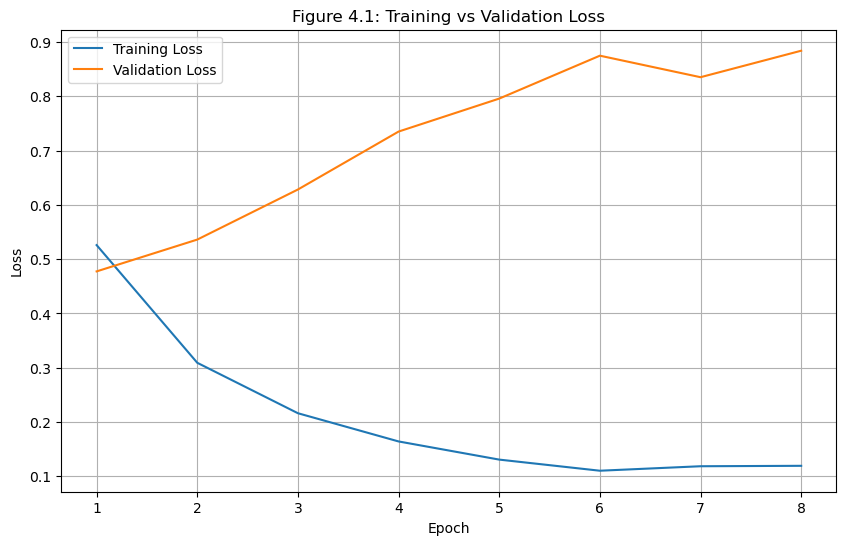

In [ ]:
# Group by epoch and calculate mean loss
mean_train_loss = df_epoch_results.groupby("epoch")["train_loss"].mean()
mean_val_loss = df_epoch_results.groupby("epoch")["val_loss"].mean()

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(mean_train_loss.index, mean_train_loss, label="Training Loss")
plt.plot(mean_val_loss.index, mean_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Figure 4.1: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Validation Accuracy and Hyperparameters


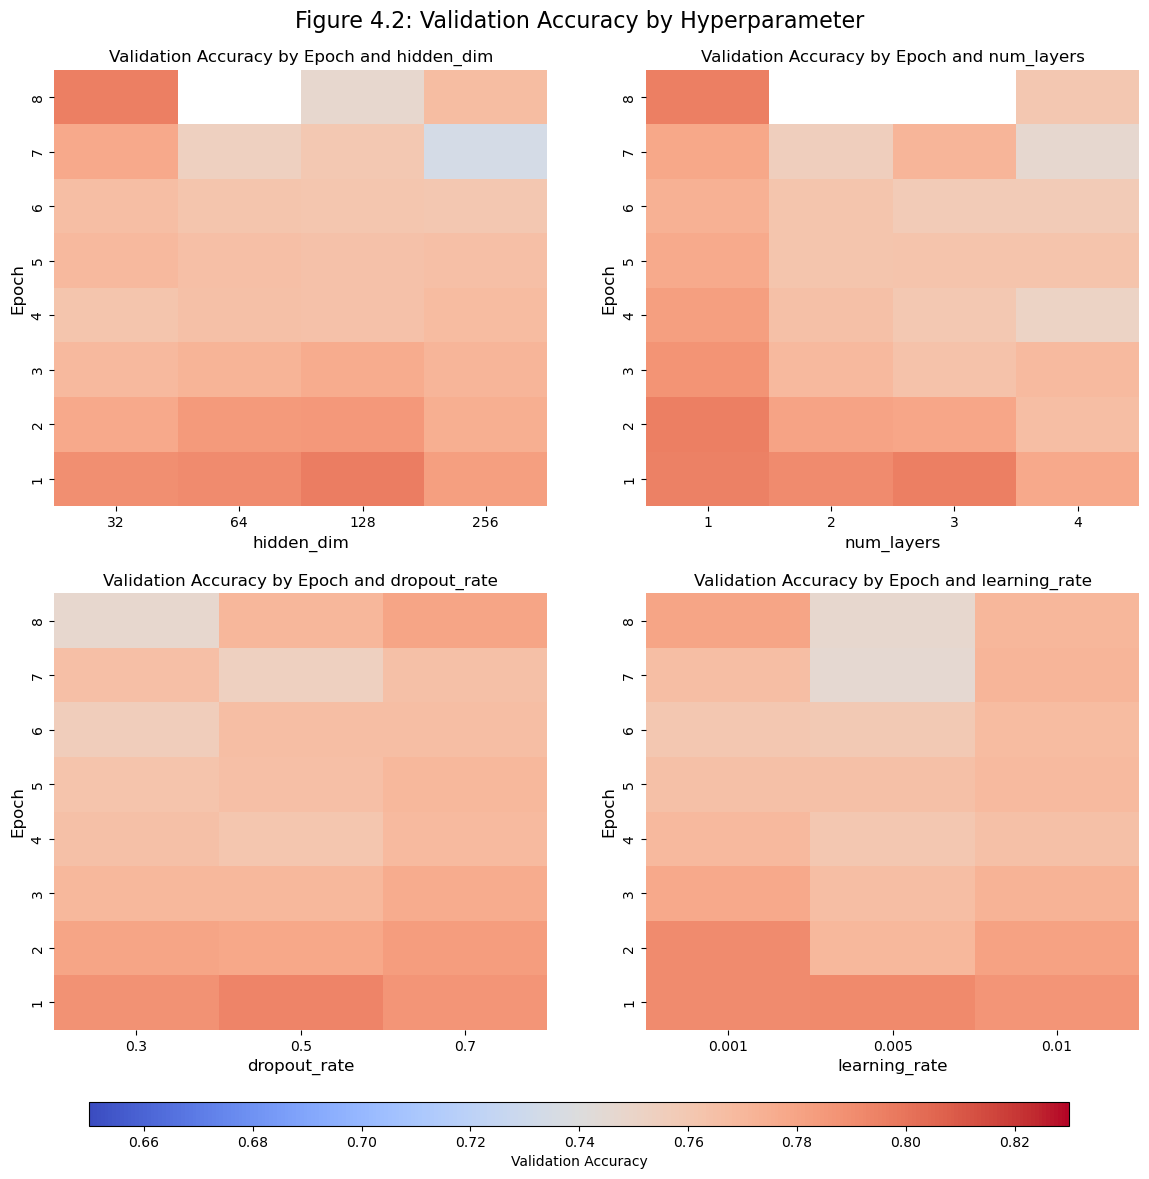

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Hyperparameters to plot
hyperparameters = ['hidden_dim', 'num_layers', 'dropout_rate', 'learning_rate']

# Define plot layout
num_cols = 2  # Number of plots per row
num_rows = -(-len(hyperparameters) // num_cols)  # Ceiling division
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
axes = axes.flatten()

# Color Scale
vmin = 0.65
vmax = 0.83

# Iterate over hyperparameters
for i, hyperparam in enumerate(hyperparameters):
    ax = axes[i]

    # Pivot table to prepare data for heatmap
    heatmap_data = df_epoch_results.pivot_table(
        index='epoch',
        columns=hyperparam,
        values='val_accuracy',
        aggfunc='mean'
    )

    # Plot heatmap with adjusted color scale
    sns.heatmap(
        heatmap_data,
        cmap="coolwarm",
        ax=ax,
        cbar=False,  # Suppress individual color bars for each subplot
        annot=False,
        vmin=vmin,  # Set the color scale minimum manually
        vmax=vmax   # Set the color scale maximum manually
    )

    ax.invert_yaxis()

    # Formatting the subplot
    ax.set_title(f"Validation Accuracy by Epoch and {hyperparam}", fontsize=12)
    ax.set_xlabel(hyperparam, fontsize=12)
    ax.set_ylabel("Epoch", fontsize=12)

for j in range(len(hyperparameters), len(axes)):
    axes[j].axis('off')

cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # Adjust positioning of the color bar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Only needed for ScalarMappable
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label="Validation Accuracy")

plt.subplots_adjust(top=0.9, bottom=0.1)  # Adjust spacing for title and color bar
fig.suptitle("Figure 4.2: Validation Accuracy by Hyperparameter", fontsize=16, y=0.95)

plt.show()


### Best Performing Model:

The best-performing model achieved a validation accuracy of 81.88% with the following hyperparameters:

In [ ]:
# Identify the best-performing model
best_model = df_epoch_results.loc[df_epoch_results["val_accuracy"].idxmax()]
print("Best Model Hyperparameters:")
print(best_model[["hidden_dim", "num_layers", "dropout_rate", "learning_rate"]])
print(f"Best Validation Accuracy: {best_model['val_accuracy']:.2%}")


Best Model Hyperparameters:
hidden_dim       128.000
num_layers         1.000
dropout_rate       0.700
learning_rate      0.001
Name: 482, dtype: float64
Best Validation Accuracy: 81.88%


## 4.3 Final Model Predictions

In [ ]:
best_model_row = df_epoch_results.loc[df_epoch_results["val_accuracy"].idxmax()]
best_hidden_dim = int(best_model_row["hidden_dim"])
best_num_layers = int(best_model_row["num_layers"])
best_dropout_rate = float(best_model_row["dropout_rate"])
best_learning_rate = float(best_model_row["learning_rate"])

filename = f"lstm_h{best_hidden_dim}_l{best_num_layers}_lr{best_learning_rate}_dr{best_dropout_rate}_best.pth"

model_directory = "."
model_path = os.path.join(model_directory, filename)

if os.path.exists(model_path):
    best_model = LSTMModel(
        hidden_dim=best_hidden_dim,
        num_layers=best_num_layers,
        dropout_rate=best_dropout_rate,
        input_dim=input_dim,  # Input dimension from earlier
        output_dim=output_dim  # Output dimension from earlier
    )

    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()

    print(f"Model {filename} loaded.")


Model lstm_h128_l1_lr0.001_dr0.7_best.pth loaded successfully.


In [ ]:
import pandas as pd
import torch

# Load the original test.csv which contains the id column
original_test_df = pd.read_csv('test.csv')

# Ensure the order of the ids is preserved
original_test_ids = original_test_df['id'].values

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
best_model.eval()

# List to store predictions
predictions = []

# Predict the outputs using the model
with torch.no_grad():
    for idx, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)

        # Append predictions with their row index to maintain the order
        for batch_idx, label in zip(range(len(predicted_labels)), predicted_labels.cpu().numpy()):
            row_index = idx * test_loader.batch_size + batch_idx
            predictions.append((row_index, label))

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=["row_index", "target"])

# Now, map the predictions back to the original ids
predictions_df["id"] = original_test_ids[predictions_df["row_index"]]

# Drop the row_index column
predictions_df = predictions_df.drop(columns=["row_index"])

# Save the predictions to a CSV
predictions_df.to_csv("test_predictions.csv", index=False)

# Optionally, save as a different file
predictions_df.to_csv("test_predictions_final.csv", index=False)


# 5 Conclusion

The analysis and experimentation conducted throughout this project revealed several important insights into the behavior of the LSTM model and the impact of hyperparameter choices on model performance.

Key Findings:

Hyperparameter Sensitivity: The performance of the LSTM model was significantly influenced by hyperparameters such as the learning rate, dropout rate, and the number of layers. For instance, moderate dropout rates helped prevent overfitting, improving the model’s ability to generalize on unseen data. However, excessively high dropout rates or overly complex architectures resulted in diminishing returns, as the model failed to capture useful patterns or overfit to noise.

Learning Rate Optimization: The learning rate emerged as a crucial factor affecting model convergence. A moderate learning rate of around 0.001 resulted in the most stable and optimal convergence, while higher rates (e.g., 0.01) led to unstable training, where the model either converged too quickly to suboptimal solutions or failed to converge altogether.

Model Architecture Considerations: The number of layers and the hidden dimension had a considerable impact on performance. The best results were achieved with 128 hidden units, striking a balance between capturing enough complexity in the data and maintaining efficiency during training. Excessively increasing these dimensions beyond a certain point, however, did not result in a significant performance improvement but did increase the computational burden.

Aspects That Contributed to Performance Improvement:

Regularization with Dropout: Dropout regularization was a major contributor to improving generalization. The models with moderate dropout rates showed reduced overfitting and better generalization to unseen data, particularly when the model complexity was high.

Balanced Hidden Layer Dimensions: Choosing 128 hidden units in the LSTM layers allowed the model to learn from the data without unnecessarily increasing the training time or computational requirements. Models with larger hidden dimensions did not offer a significant advantage in performance, highlighting the importance of selecting the appropriate size for the task.

Factors That Did Not Improve Performance:

High Learning Rates: Larger learning rates, such as 0.01, led to erratic training behavior, either causing premature convergence to poor solutions or preventing convergence altogether. This highlights the necessity of fine-tuning the learning rate to avoid such instability.

Overly Complex Models: Increasing the number of layers or hidden units beyond a certain threshold resulted in longer training times without a corresponding improvement in validation accuracy. This suggests that complexity should be carefully balanced to avoid wasting computational resources.

Future Improvements:

Advanced Hyperparameter Optimization: Experimenting with more sophisticated techniques for hyperparameter tuning, such as grid search or random search, could provide more precise control over model parameters and potentially uncover more optimal configurations.

Exploring Alternative Architectures: While LSTM models performed well, further exploration of other deep learning architectures, such as GRUs or Transformer-based models, might provide better handling of longer-term dependencies in the data and improve performance, especially in complex sequence-based tasks.

Data Augmentation and Augmented Training Techniques: If the dataset lacks sufficient variance, introducing data augmentation techniques can increase the model's robustness. For example, altering input data slightly or using synthetic data can help the model generalize better. Additionally, experimenting with different training techniques, like batch normalization or learning rate schedules, might enhance training stability and speed.

In conclusion, the findings illustrate the importance of carefully selecting hyperparameters, particularly learning rate, dropout, and model architecture. The results from these experiments contribute valuable insights into optimizing LSTM models for sequence-based tasks. Future work could focus on fine-tuning these parameters further, exploring alternative models, and augmenting the dataset to continue improving model performance.

In [ ]:
!jupyter nbconvert --to html --no-prompt --output NPL_Disaster_Tweets_Report.html NPL_Disaster_Tweets_Report.ipynb


[NbConvertApp] Converting notebook NPL_Disaster_Tweets_Report.ipynb to html
[NbConvertApp] Writing 1885596 bytes to NPL_Disaster_Tweets_Report.html
